# پروژه ۵ درس هوش

## base code

In [140]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import random

from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
from datetime import datetime


import zipfile

Step 1: Define transform classes, instantiating transform objects and instantiating the dataset.

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
z = zipfile.ZipFile('drive/My Drive/darsi/AI/Project5/categorized_products.zip')
z.extractall()

In [143]:
class CustomToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()
                               ]
                              ) ## composes multiple transforms into single one

dataset = ImageFolder( 'categorized_products'
                      , transform=transform)

## قسمت ۱

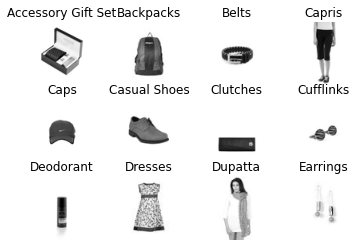

In [144]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4)
    for i in range(3):
      for j in range(4):
        axs[i][j].imshow(img_array[i * 4 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.show()

labels = []
img_array = []
for image, label in dataset:
  if label not in labels:
    labels.append(label)
    img_array.append(image)
    if len(labels) >= 12:
      break;
imshow(img_array, labels, dataset.classes)


## قسمت ۲

### الف

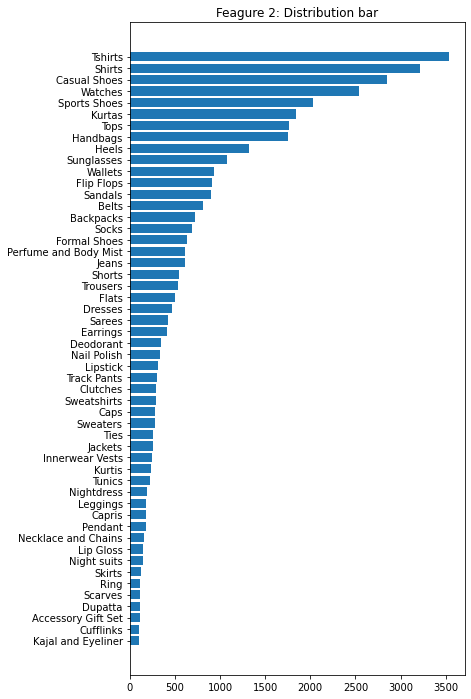

In [145]:
def get_number_distribution(dataset):
  total_category_count = {class_name : 0 for class_name in dataset.classes}
  for _, label in dataset:
    total_category_count[ dataset.classes[label] ] += 1
  
  items = list(total_category_count.items())
  sorted_items = sorted(items, key=lambda x: x[1], reverse=True)

  fig, ax = plt.subplots(figsize=(6,12))
  plt.barh(np.arange(len(sorted_items)), [val for _, val in sorted_items])
  plt.yticks(np.arange(len(sorted_items)), [key for key ,_ in sorted_items])
  ax.set_title('Feagure 2: Distribution bar')
  ax.invert_yaxis()
  plt.show()

get_number_distribution(dataset)


### ب

In [146]:
def split_dataset(dataset, validation_split=0.2, batch_size=64):
  # TODO: split the dataset into train and test sets randomly with split of 0.2 and assign their indices in the original set to train_indices and test_indices 

  targets = dataset.targets
  random_seed= 42
  train_indices, test_indices = train_test_split(np.arange(len(targets)), test_size=validation_split, random_state=random_seed, shuffle=True, stratify=targets)
  
  # Creating PT data samplers and loaders:
  train_sampler = SubsetRandomSampler(train_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)
  print(len(dataset), len(train_loader), len(test_loader))
  return train_loader, test_loader

train_loader, test_loader = split_dataset(dataset)

37249 466 117


## قسمت ۳

### base code

In [147]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.relu):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 20 * 20 * 20)
        self.act1 = act

        self.layer2 = nn.Linear(20 * 20 * 20, 35 * 20 * 10)
        self.act2 = act

        self.layer3 = nn.Linear(35 * 20 * 10, 40 * 10 * 5)
        self.act3 = act

        self.layer4 = nn.Linear(40 * 10 * 5, 10 * 10 * 5 )
        self.act4 = act

        self.layer5 = nn.Linear(10 * 10 * 5, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [149]:
print(device)

cuda:0


In [150]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
  train_losses = []
  total_time = 0.

  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        # print(outputs)
        # print(labels)
        # print(loss)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss = train_loss / len(train_loader)
      train_losses.append(average_loss)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))
  fig, ax = plt.subplots(figsize=(10,6))
  plt.bar(np.arange(len(train_losses)), train_losses)
  plt.xticks(np.arange(len(train_losses)), np.arange(len(train_losses)))
  ax.set_title('Feagure 1: train loss over epoch')
  plt.show()

In [151]:
def test_model_accuracy(model, train_loader, test_loader, classes):
    
  def loader_accuracy(model, loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    accuracy_per_classes = [[0, 0] for class_name in classes]
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
          label = labels[i]
          accuracy_per_classes[label][1] += 1
          total += 1
          if predicted[i] == label:
            correct += 1
            accuracy_per_classes[label][0] += 1

    accuracy = 100 * correct / total
    
    for category_index in range(len(accuracy_per_classes)):
      category_correct, category_total = accuracy_per_classes[category_index]
      if category_total:
        accuracy_per_classes[category_index] = 100 * category_correct / category_total
      else:
        accuracy_per_classes[category_index] = 0
    
    return accuracy, accuracy_per_classes

  train_accuracy, train_accuracy_per_classes = loader_accuracy(model, train_loader, classes)
  test_accuracy, test_accuracy_per_classes = loader_accuracy(model, test_loader, classes)

  print(f'Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}')
  print('\n---------------- Train and Test accuracy for each class----------------\n')

  x = np.arange(len(classes))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(30,5))
  rects1 = ax.bar(x - width/2, train_accuracy_per_classes, width, label='Train')
  rects2 = ax.bar(x + width/2, test_accuracy_per_classes, width, label='Test')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Recall')
  ax.set_title('Recall by class and samples')
  ax.set_xticks(x)
  ax.set_xticklabels(classes)
  ax.legend()


  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}%'.format(int(height)),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  autolabel(rects1)
  autolabel(rects2)

  fig.tight_layout()

  plt.show()

In [152]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### الف

In [153]:
print(model.parameters)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'\nmodel has {pytorch_total_params} parameters')
print(f'parameter vector for each layer')
for name, parameter in model.named_parameters():
  print(f'{name}, {len(parameter)} * {len(parameter[0]) if parameter[0].dim() != 0 else 1}')
  print("--------------")



<bound method Module.parameters of Model(
  (layer1): Linear(in_features=4800, out_features=8000, bias=True)
  (layer2): Linear(in_features=8000, out_features=7000, bias=True)
  (layer3): Linear(in_features=7000, out_features=2000, bias=True)
  (layer4): Linear(in_features=2000, out_features=500, bias=True)
  (layer5): Linear(in_features=500, out_features=52, bias=True)
)>

model has 109443552 parameters
parameter vector for each layer
layer1.weight, 8000 * 4800
--------------
layer1.bias, 8000 * 1
--------------
layer2.weight, 7000 * 8000
--------------
layer2.bias, 7000 * 1
--------------
layer3.weight, 2000 * 7000
--------------
layer3.bias, 2000 * 1
--------------
layer4.weight, 500 * 2000
--------------
layer4.bias, 500 * 1
--------------
layer5.weight, 52 * 500
--------------
layer5.bias, 52 * 1
--------------


هر لایه یک وزن و یک بایاس داره، وکتور وزن یک وکتور ۲ بعدی ه که در بعد اولش به اندازه‌ی تعداد نورون های اون لایه (خروجی لایه) هست و در بعد بعدی اندازش برابر با ورودی اون لایه است 
وکتور بایاس هم یک آرایه یک بعدیه به اندازه تعداد نورون های اون لایه (تعداد خروجی) که در نتیجه جمع عناصر تمام این وکتور ها برابر با تعداد کل پارامتر های مدل است 

### ب

epoch 1, train_loss: nan, time elapsed: 14.587338 seconds
epoch 2, train_loss: nan, time elapsed: 14.60801 seconds
epoch 3, train_loss: nan, time elapsed: 14.631061 seconds
epoch 4, train_loss: nan, time elapsed: 14.587051 seconds
epoch 5, train_loss: nan, time elapsed: 14.443993 seconds
epoch 6, train_loss: nan, time elapsed: 14.49899 seconds
epoch 7, train_loss: nan, time elapsed: 14.486196 seconds
epoch 8, train_loss: nan, time elapsed: 14.489268 seconds
epoch 9, train_loss: nan, time elapsed: 14.481914 seconds
epoch 10, train_loss: nan, time elapsed: 14.448571 seconds
total training time: 2.421 minutes


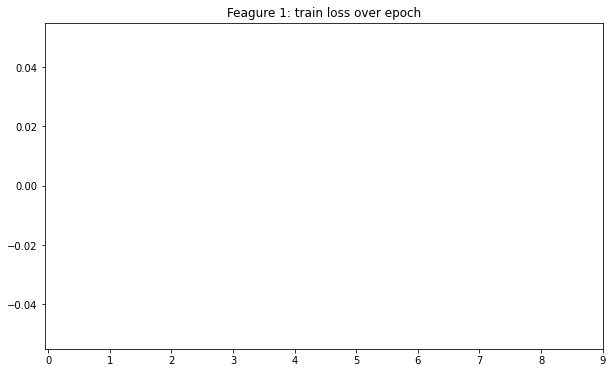

Train accuracy: 0.29866774052820566, Test accuracy: 0.2953020134228188

---------------- Train and Test accuracy for each class----------------



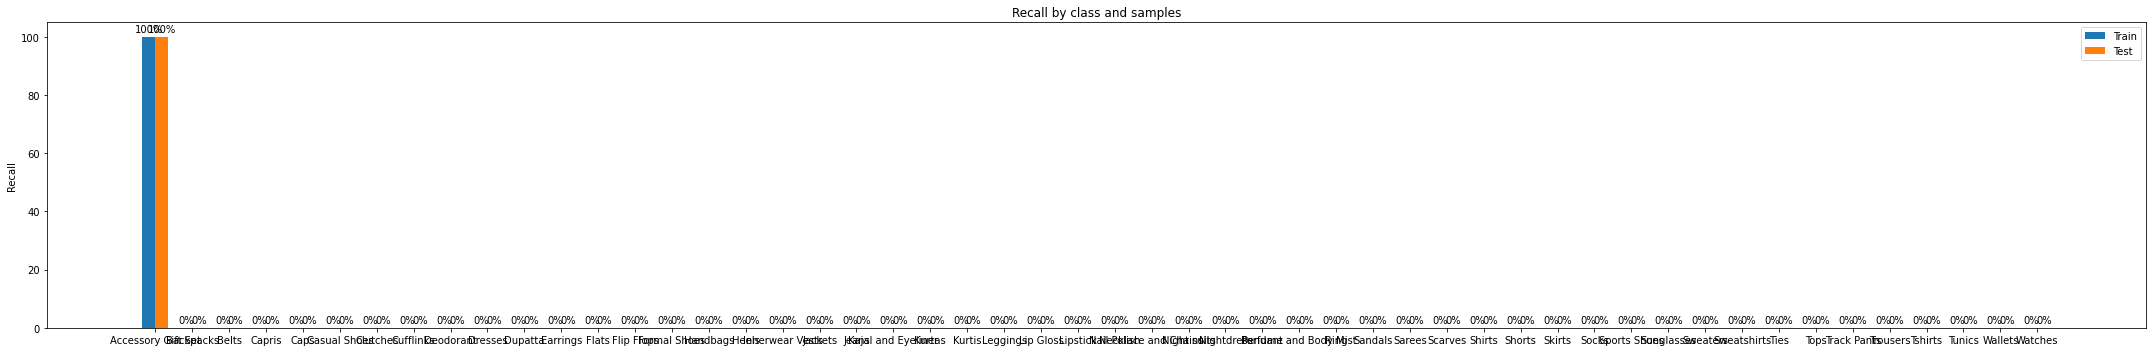

In [154]:
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

## قسمت ۴

In [155]:
class CustomToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)

transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor(),
                               ]
                              )
dataset = ImageFolder('categorized_products' ,transform=transform)
train_loader, test_loader = split_dataset(dataset, validation_split, batch_size)

# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

37249 466 117


epoch 1, train_loss: 3.393, time elapsed: 15.050129 seconds
epoch 2, train_loss: 2.695, time elapsed: 14.994463 seconds
epoch 3, train_loss: 2.268, time elapsed: 14.968522 seconds
epoch 4, train_loss: 1.950, time elapsed: 15.00097 seconds
epoch 5, train_loss: 1.756, time elapsed: 14.983347 seconds
epoch 6, train_loss: 1.624, time elapsed: 14.980257 seconds
epoch 7, train_loss: 1.532, time elapsed: 15.065256 seconds
epoch 8, train_loss: 1.452, time elapsed: 15.068928 seconds
epoch 9, train_loss: 1.392, time elapsed: 15.093375 seconds
epoch 10, train_loss: 1.327, time elapsed: 15.012486 seconds
total training time: 2.504 minutes


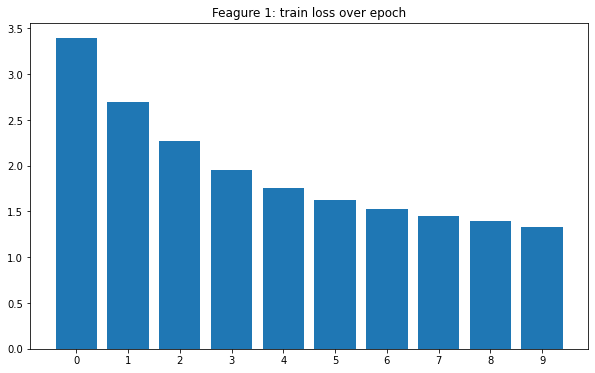

Train accuracy: 53.59575824692104, Test accuracy: 53.57046979865772

---------------- Train and Test accuracy for each class----------------



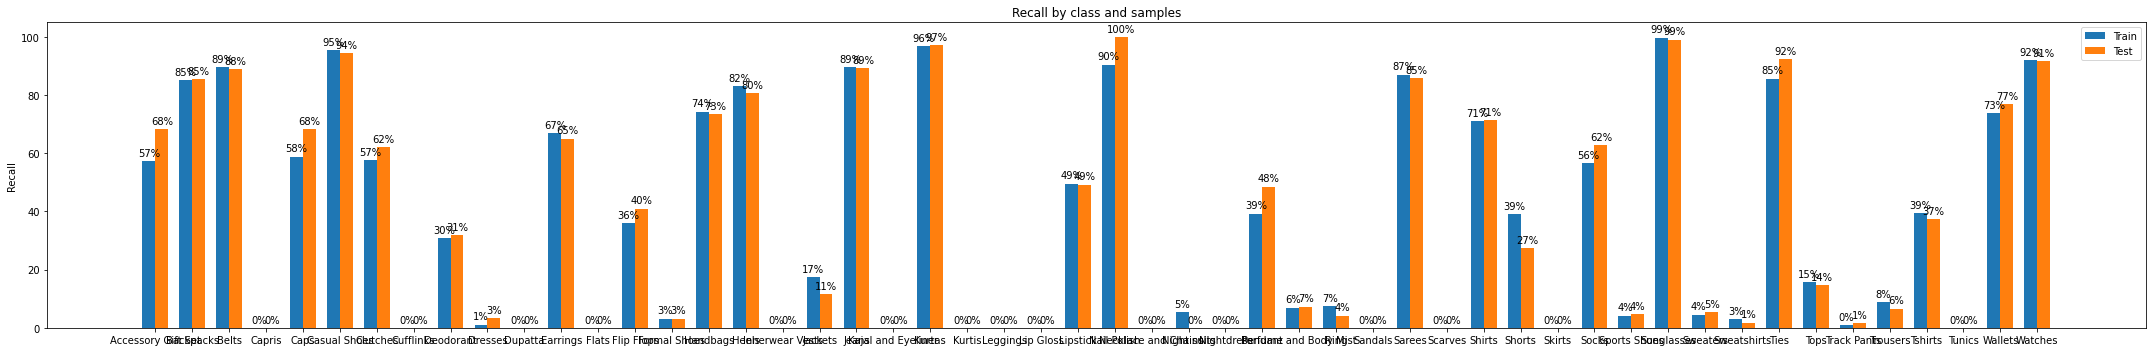

In [156]:
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

این نرمال کردنه خیلی تاثیر گذاشت روی خروجی مدلمون، کلا نرمال کردن کار خوبیه و فرآیند آموزش رو میتونه سریعتر کنه در شبکه های عصبی، حس میکنم چون از اکشن رلو استفاده میکنیم آپتیمایزرمون با داده های داخل بازه‌ی ۰ تا ۱ بهتر کار میکنه

## قسمت ۵

### الف

In [158]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for name, parameters in model.named_parameters():
  if name == 'layer1.weight':
    print(parameters)

Parameter containing:
tensor([[-0.0114, -0.0034, -0.0093,  ..., -0.0108, -0.0111, -0.0036],
        [ 0.0021,  0.0059, -0.0082,  ..., -0.0113,  0.0135,  0.0034],
        [-0.0095, -0.0127, -0.0014,  ..., -0.0133,  0.0003, -0.0103],
        ...,
        [ 0.0143, -0.0040, -0.0074,  ..., -0.0078,  0.0050, -0.0053],
        [ 0.0108,  0.0023,  0.0015,  ...,  0.0091,  0.0141,  0.0008],
        [-0.0003,  0.0041, -0.0063,  ..., -0.0072,  0.0131, -0.0123]],
       device='cuda:0', requires_grad=True)


همون طور که دیده میشه پایتورچ به صورت دیفالت مقادیر رندوم برای وزن ها انتخاب میکنه و میزاره

In [159]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
model.apply(init_weights)

for name, parameters in model.named_parameters():
  if name == 'layer1.weight':
    print(parameters)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


در اینجا همونطور که مشاهده میشه وزن ها رو صفر کردیم
حالا با این مدل ترین و تست میکنیم

epoch 1, train_loss: 3.888, time elapsed: 14.930836 seconds
epoch 2, train_loss: 3.783, time elapsed: 15.018636 seconds
epoch 3, train_loss: 3.687, time elapsed: 14.891286 seconds
epoch 4, train_loss: 3.597, time elapsed: 14.933335 seconds
epoch 5, train_loss: 3.529, time elapsed: 14.917649 seconds
epoch 6, train_loss: 3.491, time elapsed: 14.901458 seconds
epoch 7, train_loss: 3.473, time elapsed: 14.889248 seconds
epoch 8, train_loss: 3.463, time elapsed: 14.843341 seconds
epoch 9, train_loss: 3.458, time elapsed: 14.884689 seconds
epoch 10, train_loss: 3.455, time elapsed: 14.778408 seconds
total training time: 2.483 minutes


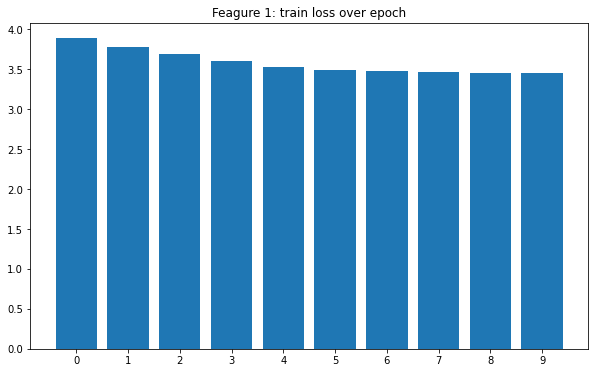

Train accuracy: 9.48689553340716, Test accuracy: 9.48993288590604

---------------- Train and Test accuracy for each class----------------



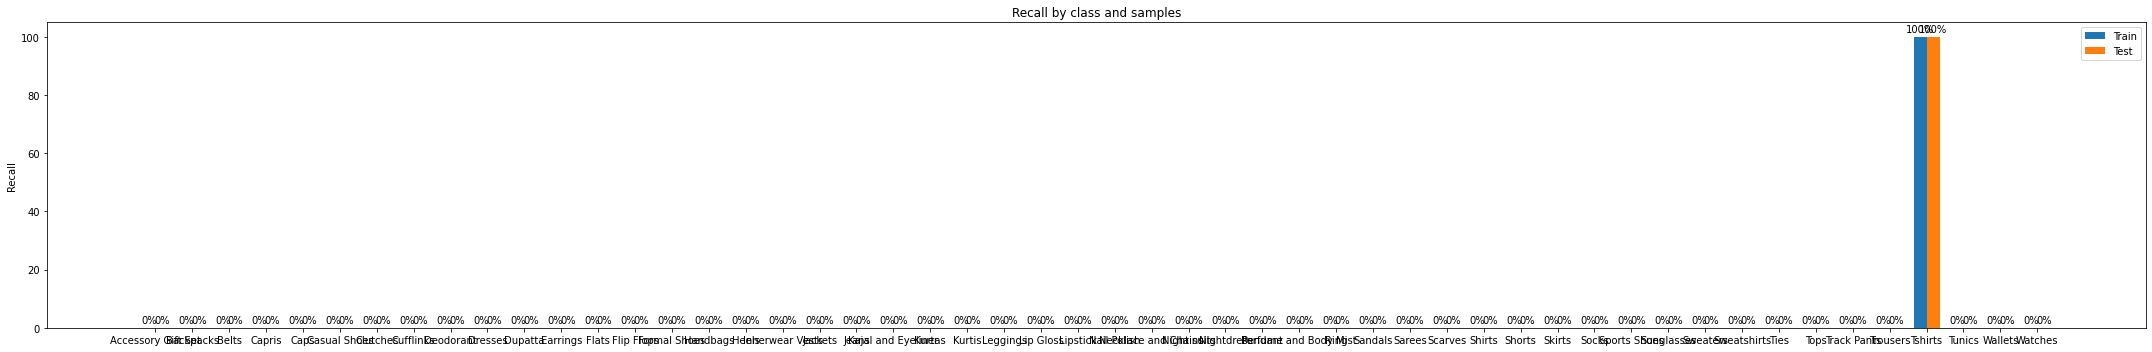

In [160]:
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

همونطوری که مشاهده میشه مقدار ترین لاسمون در طول اپوک ها کم نمیشه، اکورسی بعد ترین هم نزدیک به ۱۰ درصده که مقدار خوبی نیست



وقتی همه‌ی وزن ها رو به یک مقدار مساوی اساین میکنیم اتفاقی که میوفته اینه که چون همه‌ی نورون هامون وزن مساوی دارن همه‌شون به یک شکل رفتار و خروجی میدن و در این صورت پیدا کردن وزنی که باید تغییر بدیم و مدیفای کنیم در زمان بک پروپگیت سخت میشه و سیستم گاها مجبور میشه به صورت رندوم انتخاب کنه، همین قضیه باعث میشه نتونیم بعد از اپوک های متوالی ترین لاس رو کم کنیم 

### ب

همون طور که دیدیم گذاشتن مقدار ثابت برای وزن ها کار خوبی نیست و باعث میشه مدل به خوبی ترین نشه

پس باید از مقدار رندوم استفاده کنیم، مثلا از دیستریبیوشن یونیفورم بین یک بازه مثل ۰ و ۱ مثلا، اینجوری مدل بهتر آموزش میبینه اما این نحوه‌ی وزن دهی هم مشکلات خودش رو داره، مقادیر میتونه به ۱ نزدیک بشه که خیلی مقدار بزرگیه و این مقدار بزرگ در فرآیند ترین هم تاثیر گذاره و سیستم تا بخواد این وزن های بزرگ رو اصلاح و کم کنه چندین اپوک طول میکشه

راه حلی که برای این قضیه هست و راه حل مناسب اینه که مقدایر رو به صورت رندوم برداریم ولی از بازه‌ی اعداد کوچک تر
برای اینکار معمولا اعداد رو از بازه‌ی

`(-y, y)`

برمیداریم که

`y = 1/sqrt(n)` where n is input number of each nouron


## قسمت ۶

### الف

اول بردمش روی ۲.۵ درصد که نزدیک به ۵ درصد اکورسی کلی بیشتر شد

با پایین بردنش به ۴ صدم درصدتقریبا اکورسی ۱۰ درصد اومد پایین

در نتیجه لرنینگ ریت برای مدل من و با توجه به تعداد بچ ها باید بالاتر بره

با چند بار بالا و پایین بردن مقدار لرنینگ ریت به مقدار ۳.۵ درصد رسیدم که مقدار اکورسی رو به مقدار خیلی خوبی بالا میبرد

معمولا در طول این عملیات با زیاد شدن اکورسی ترین لاس هم در عملیات آموزش مقدارش کمتر میشد

epoch 1, train_loss: 2.902, time elapsed: 15.029362 seconds
epoch 2, train_loss: 2.042, time elapsed: 14.924056 seconds
epoch 3, train_loss: 1.723, time elapsed: 14.945396 seconds
epoch 4, train_loss: 1.521, time elapsed: 14.918093 seconds
epoch 5, train_loss: 1.398, time elapsed: 14.840645 seconds
epoch 6, train_loss: 1.286, time elapsed: 15.103016 seconds
epoch 7, train_loss: 1.212, time elapsed: 14.985035 seconds
epoch 8, train_loss: 1.151, time elapsed: 14.941276 seconds
epoch 9, train_loss: 1.094, time elapsed: 14.889384 seconds
epoch 10, train_loss: 1.061, time elapsed: 14.885336 seconds
total training time: 2.491 minutes


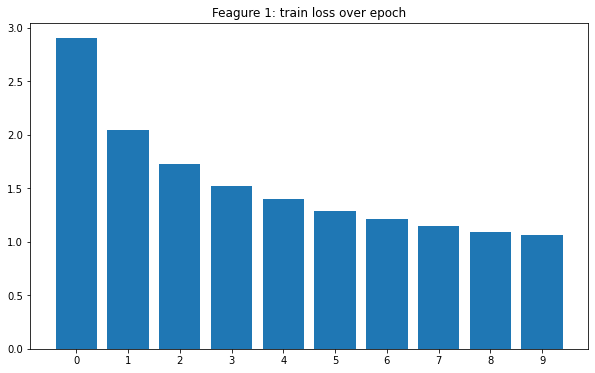

Train accuracy: 61.30742642370549, Test accuracy: 60.80536912751678

---------------- Train and Test accuracy for each class----------------



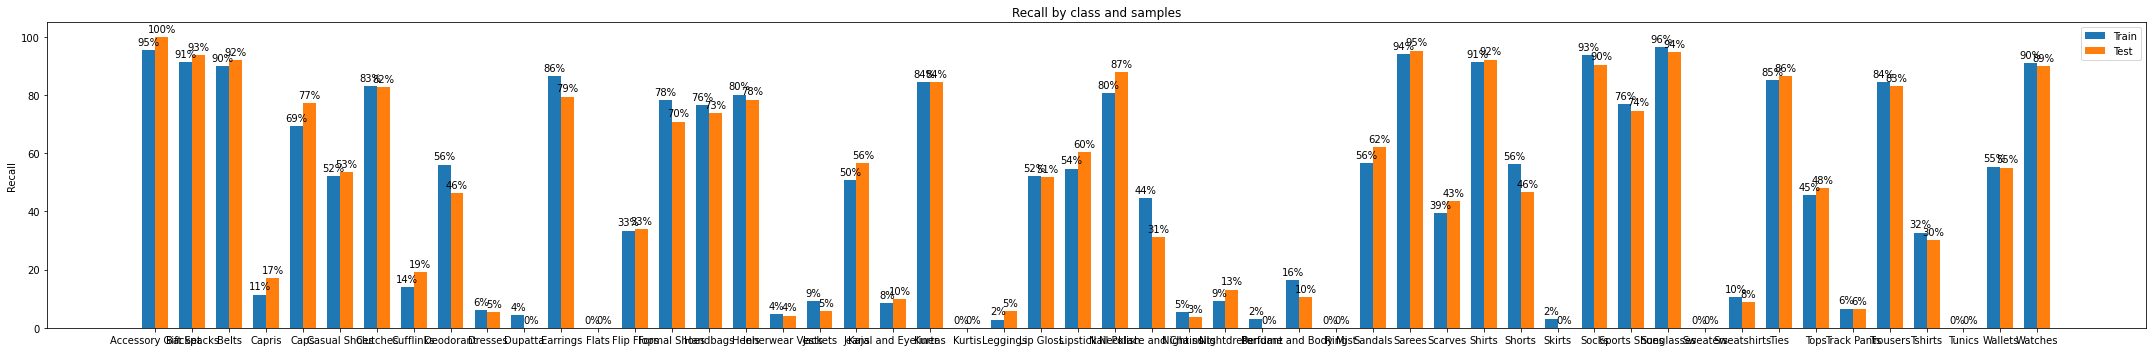

In [161]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

### ب

با بالارفتن لرنینگ ریت به مقدار ۱۰ درصد هر کدام از استپ های آپتیمایز که به ازای هر بتچ رخ میده در عملیات بکوارد پروپگیشن وزن ها سریع تر و بیشتر آپدیت میشن به عبارتی مدل سریع تر ترین میشه و تغییرات وزن ها در هنگام لاس خیلی بیشتر این تغییرات شدید باعث نوسان در طول اپوک های مختلف میشه و وزن ها هی بالا و پایین میرن و در مقادیر خیلی زیاد لرنینگ ریت حتی ممکنه واگرا بشه و هیچ گاه مقدار درستی پیدا نکنه

از اونور کم کردن مقدار لرنینگ ریت باعث میشه وزن ها خیلی آروم تغییر کنن، به دلیل کند بودن آپدیت شدن وزن ها وزن ها همگرا به مقداری خواهند بود اما اگه این لرنینگ ریت خیلی کوچیک باشه با توجه به محدود بودن تعداد استپ های آپتیمایز ممکنه وزن هیچ وقت به مقدار مناسب خودش نرسه و فقط در جهت رسیدن به اون مقدار خیلی کم تغییر کنه 

epoch 1, train_loss: 2.974, time elapsed: 15.037978 seconds
epoch 2, train_loss: 2.236, time elapsed: 14.877868 seconds
epoch 3, train_loss: 1.841, time elapsed: 14.973408 seconds
epoch 4, train_loss: 1.585, time elapsed: 14.888234 seconds
epoch 5, train_loss: 1.415, time elapsed: 14.72475 seconds
epoch 6, train_loss: 1.327, time elapsed: 14.763237 seconds
epoch 7, train_loss: 1.227, time elapsed: 14.84587 seconds
epoch 8, train_loss: 1.161, time elapsed: 14.82754 seconds
epoch 10, train_loss: 1.038, time elapsed: 14.904334 seconds
total training time: 2.480 minutes


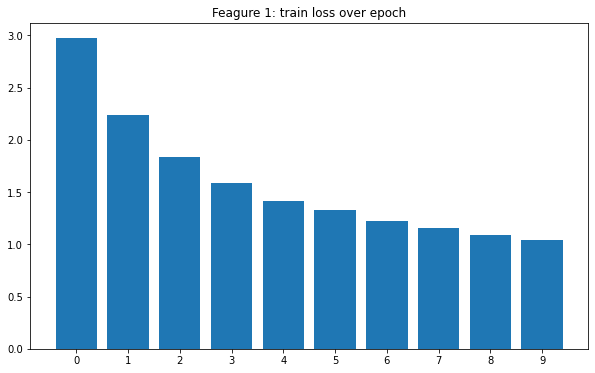

Train accuracy: 67.01231584952515, Test accuracy: 65.30201342281879

---------------- Train and Test accuracy for each class----------------



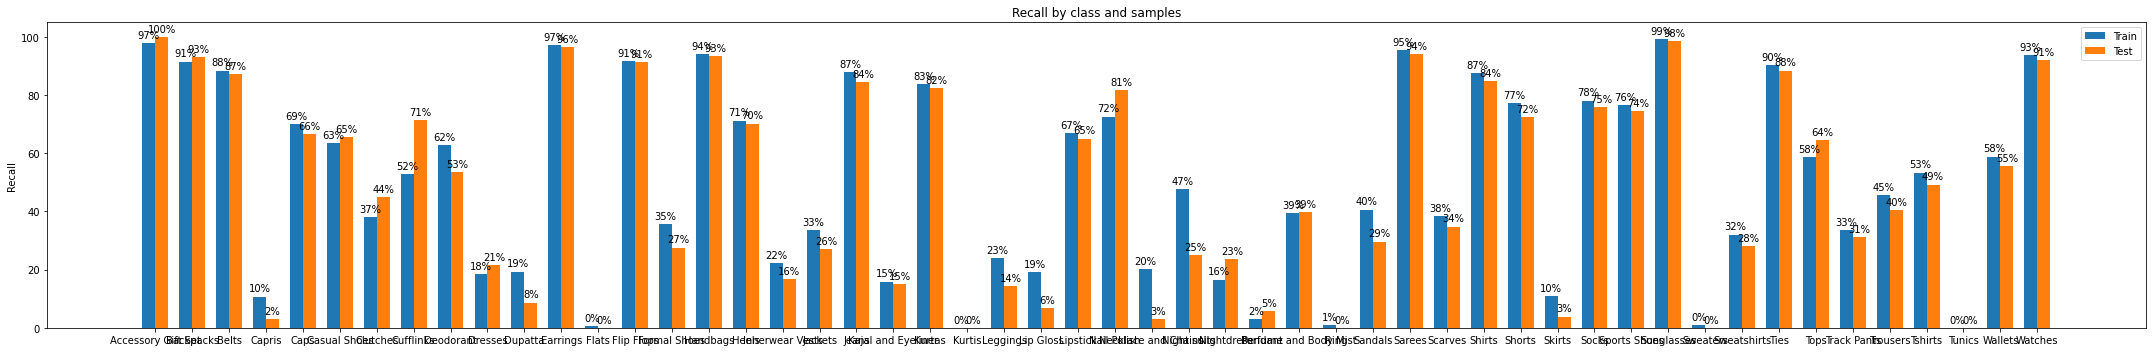

In [162]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

در اینجا مقادیر لرنینگ ریت رو ۱۰ درصد گذاشتیم این مقدار زیاد نسبت به مقدار مناسب ۳.۵ درصد بالا دارای ترین لاس های بیشتر در هر اپوک هستش دلیلش هم اینه که وزن ها در یک لاس خیلی زیاد و شدید تغییر میکنن و این باعث میشه یه سری داده هایی که قبلا مدلمون درست دسته بندی میکرد رو در اپوک بعدی اشتباه دسته بندی کنه و در نتیجه مقداری ترین لاس اپوک بعدی بیشتر میشه

اکورسی هم پایین تر اومده

epoch 1, train_loss: 3.884, time elapsed: 14.978366 seconds
epoch 2, train_loss: 3.600, time elapsed: 14.790897 seconds
epoch 3, train_loss: 3.457, time elapsed: 14.802869 seconds
epoch 4, train_loss: 3.429, time elapsed: 14.879054 seconds
epoch 5, train_loss: 3.405, time elapsed: 14.860008 seconds
epoch 6, train_loss: 3.369, time elapsed: 15.005978 seconds
epoch 7, train_loss: 3.303, time elapsed: 14.850449 seconds
epoch 8, train_loss: 3.190, time elapsed: 14.834057 seconds
epoch 9, train_loss: 3.053, time elapsed: 14.786139 seconds
epoch 10, train_loss: 2.936, time elapsed: 14.876238 seconds
total training time: 2.478 minutes


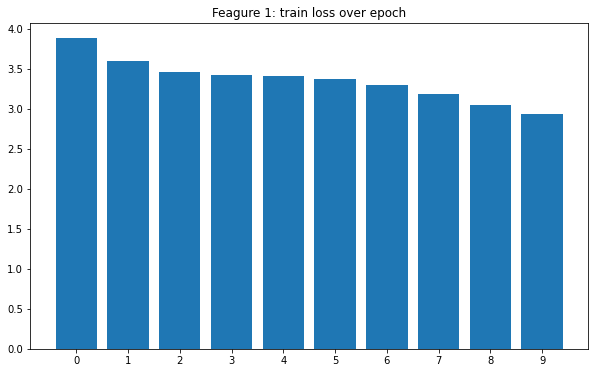

Train accuracy: 22.453773616564312, Test accuracy: 22.25503355704698

---------------- Train and Test accuracy for each class----------------



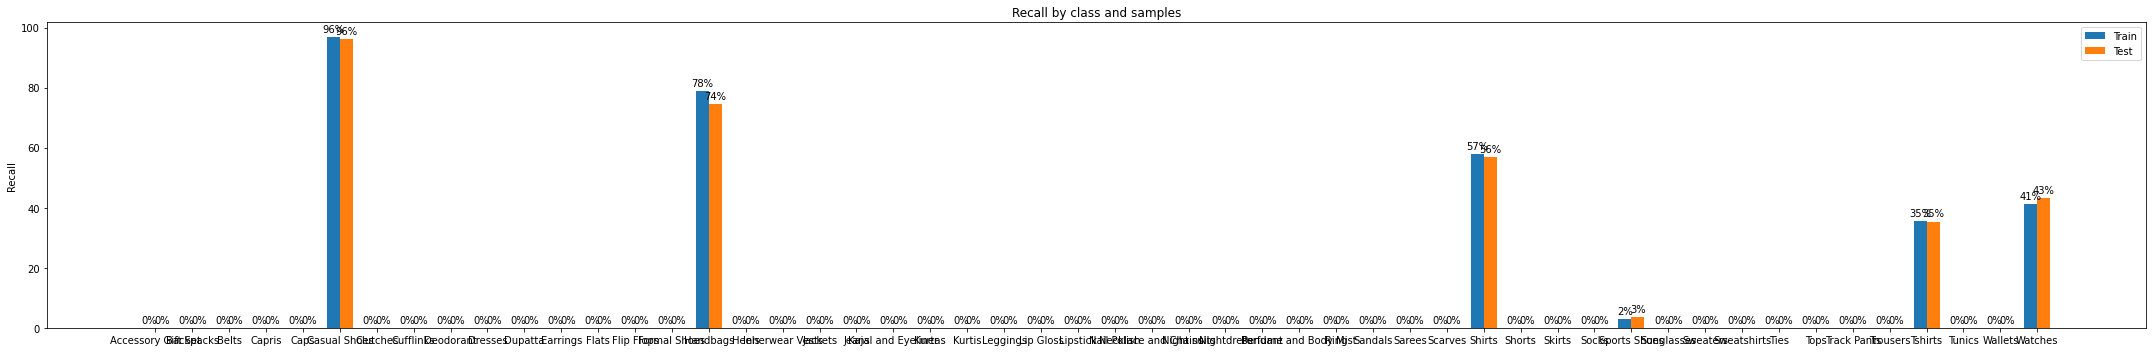

In [163]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

در اینجا ما لرنینگ ریت رو خیلی کم گذاشتیم که باعث میشه عملیات ترین خیلی کند جلو بره و تغییرات ترین لاس در طول اپوک ها خیلی کم بشه، در نتیجه مدل در طول استپ های محدودی که داره نمی‌تونه خودش رو به درستی ترین کنه
ترین لاس روی ۳ باقیمونده و اکورسی هم به شدت پایین اومده

## قسمت ۷

### الف

بچ سایز تعداد سمپل هایی که آپتیمایزرمون بر اساس لاس اونها آپتیمایز رو انجام میده، به عبارتی آپتیمایزر وزن ها رو جوری آپدیت میکنه که برای اون بچ بهترین نتیجه رو بده یا به عبارتی آپتیمایز بشه

 بر اساس درسی که استاد دادن چند مدل داره یکی فول سمپله که هر دفعه الگوریتم آپتیمایزر رو روی کل سمپل اجرا کنیم، مینی بچ که حالتیه که ما اینجا داریم استفاده میکنیم و در نهایت مدل یک سمپله که هر دفعه یک سمپل رو میدیم به آپتیمایزرمون

معمولا زیاد کردن بچ سایز باعث بهبود عملکرد میشه، بهترین مدل فول سمپله که بر اساس تمام سمپلمون آپتیمایز کنیم، البته این قضیه مشکلاتی رو هم داره اول اینکه با زیاد کردن بچ سایز ممکنه جی‌پی‌یو نتونه عملیات ترین رو به سادگی انجام بده در نتیجه زیاد کردنش ریسورس و زمان بیشتری میخواد، نکته‌ی دوم این زیاد کردن باعث اورفیت شدن مدل میشه طوری که اکورسی برای داده های آموزشی بیشتر داده های تست میشه، یه مشکل دیگه ائی که نمیدونم درسته اما حس میکنم اتفاق میوفته اینه که توی حالت فول سمپل ممکنه توی نقاط مینیموم لوکالی بیوفتیم و دیگه مدلمون بهبود پیدا نکنه اما توی حالت مینی بچ امکانش هست که توی مینیموم لوکالی گیر نیوفتیم

کم کردن بچ سایز باعث میشه تعداد آپدیت ها توی هر اپوک بیشتر بشه و بعضی از این  آپدیت ها میتونن نویز باشن، البته همین نویز ها میتونن باعث بشن مدل اورفیت نشه


37249 932 233
epoch 1, train_loss: 2.588, time elapsed: 20.414372 seconds
epoch 2, train_loss: 1.736, time elapsed: 20.381704 seconds
epoch 3, train_loss: 1.457, time elapsed: 20.427724 seconds
epoch 4, train_loss: 1.308, time elapsed: 20.40729 seconds
epoch 5, train_loss: 1.215, time elapsed: 20.418786 seconds
epoch 6, train_loss: 1.126, time elapsed: 20.384737 seconds
epoch 7, train_loss: 1.061, time elapsed: 20.352057 seconds
epoch 8, train_loss: 1.003, time elapsed: 20.441706 seconds
epoch 9, train_loss: 0.960, time elapsed: 20.667582 seconds
epoch 10, train_loss: 0.930, time elapsed: 20.434496 seconds
total training time: 3.406 minutes


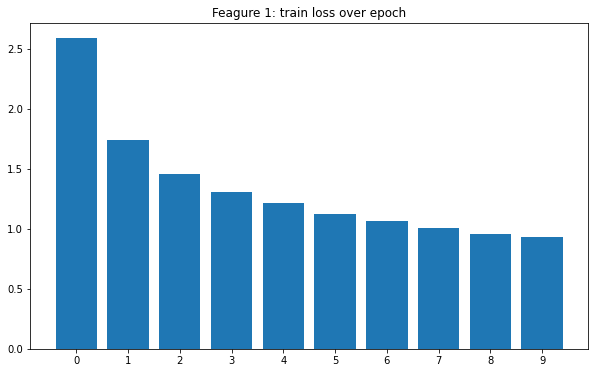

Train accuracy: 52.6863317560992, Test accuracy: 51.89261744966443

---------------- Train and Test accuracy for each class----------------



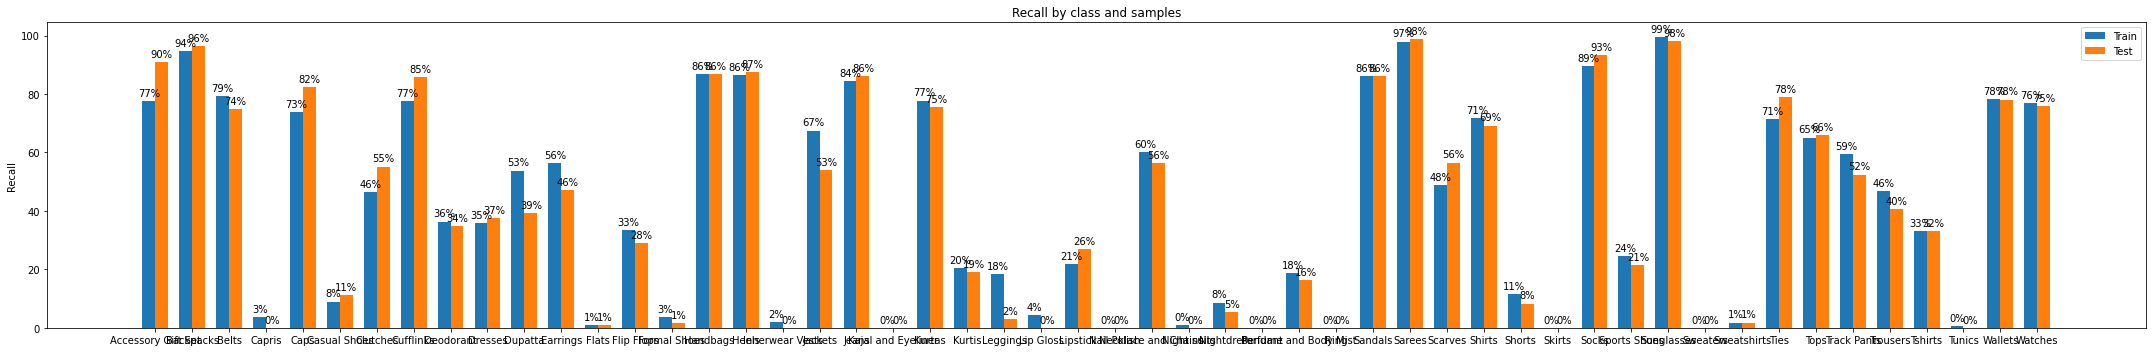

In [164]:
train_loader, test_loader = split_dataset(dataset, batch_size=32)

# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

همونطور که مشاهده میشه اکورسی پایین اومد البته اگه به مقادیر اکورسی بین ترین و تست نگاه کنیم میبینم آندرفیتینگ رخ داده در این کیس خاص پس ۳۲ چندان مقدار مناسبی نیست برای مدل ما

37249 233 59
epoch 1, train_loss: 3.244, time elapsed: 12.122944 seconds
epoch 2, train_loss: 2.483, time elapsed: 12.001367 seconds
epoch 3, train_loss: 2.091, time elapsed: 11.965639 seconds
epoch 4, train_loss: 1.881, time elapsed: 12.025443 seconds
epoch 5, train_loss: 1.717, time elapsed: 11.97395 seconds
epoch 6, train_loss: 1.600, time elapsed: 11.942018 seconds
epoch 7, train_loss: 1.490, time elapsed: 11.924775 seconds
epoch 8, train_loss: 1.410, time elapsed: 12.048331 seconds
epoch 9, train_loss: 1.335, time elapsed: 11.948766 seconds
epoch 10, train_loss: 1.286, time elapsed: 11.904879 seconds
total training time: 1.998 minutes


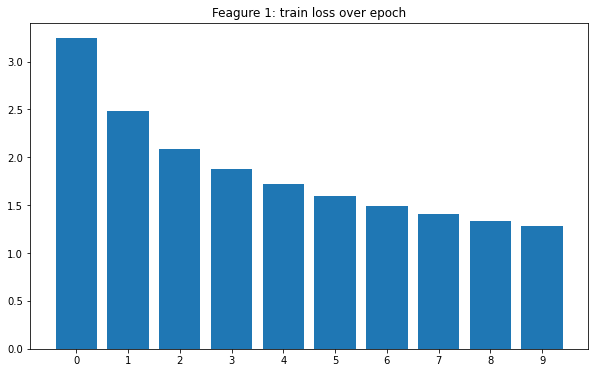

Train accuracy: 52.105775361589316, Test accuracy: 51.70469798657718

---------------- Train and Test accuracy for each class----------------



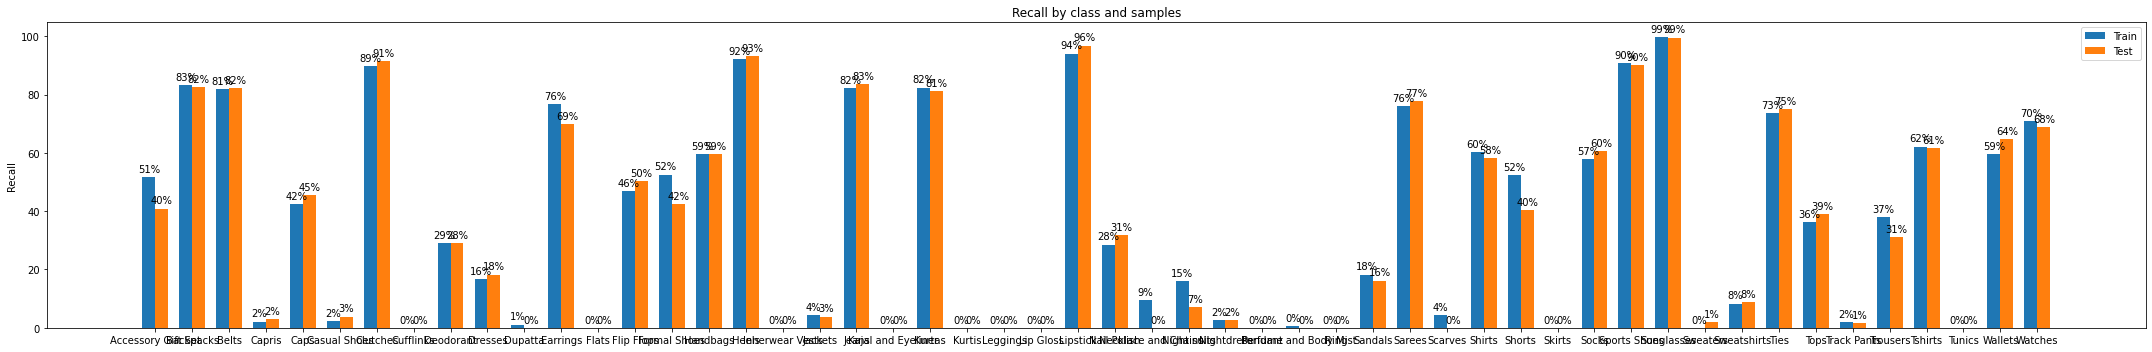

In [165]:
train_loader, test_loader = split_dataset(dataset, batch_size=128)

# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

### ب

با زیاد کردن بچ سایز تعداد آپدیت ها در هر اپوک کم میشه، همونجور که قبلا گفته شده بود لرنینگ ریت کم به دلیل کند بودن نیاز به آپدیت های زیادتری داره تا وزن ها به مقدار مناسب خودشون مجانب شن

از اونور ولی میتونیم لرنینگ ریت رو ببریم بالا چون که لرنینگ ریت زیاد نیاز به آپدیت های کمتری داره، لازم نیست نیازی به نویز دار شدن مدلمون با بالابردن لرنینگ ریت داشته باشیم چون که بچ سایز زیاد این مشکل رو حل میکنه

پس با زیاد کردن بچ سایز باید لرنینگ ریت رو هم زیاد کنیم که نتیجه بهتری بگیریم
مثلا اگه از مدل فول سمپل به عنوان بچ استفاده کنیم میتونیم لرنینگ ریت رو ۱۰۰ درصد بزاریم چون که وقتی آپتیمایزر برای کل سمپل های آموزشیمون آپتیمایز رو انجام داده پس میتونیم با تاثیر ۱۰۰ درصدی وزن ها رو آپدیت کنیم و نیازی به اپوک های بیشتری هم نداریم دیگه



37249 233 59
epoch 1, train_loss: 3.294, time elapsed: 11.926289 seconds
epoch 2, train_loss: 2.535, time elapsed: 12.009719 seconds
epoch 3, train_loss: 2.119, time elapsed: 12.089416 seconds
epoch 4, train_loss: 1.904, time elapsed: 11.895354 seconds
epoch 5, train_loss: 1.748, time elapsed: 11.916848 seconds
epoch 6, train_loss: 1.621, time elapsed: 11.867756 seconds
epoch 7, train_loss: 1.538, time elapsed: 11.831651 seconds
epoch 8, train_loss: 1.423, time elapsed: 11.854359 seconds
epoch 9, train_loss: 1.396, time elapsed: 11.917521 seconds
epoch 10, train_loss: 1.306, time elapsed: 11.992062 seconds
total training time: 1.988 minutes


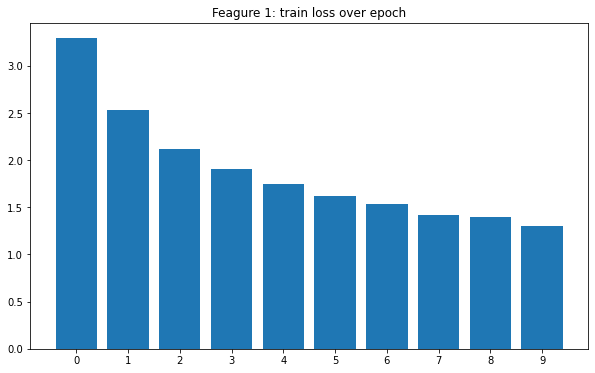

Train accuracy: 54.008523775965635, Test accuracy: 53.07382550335571

---------------- Train and Test accuracy for each class----------------



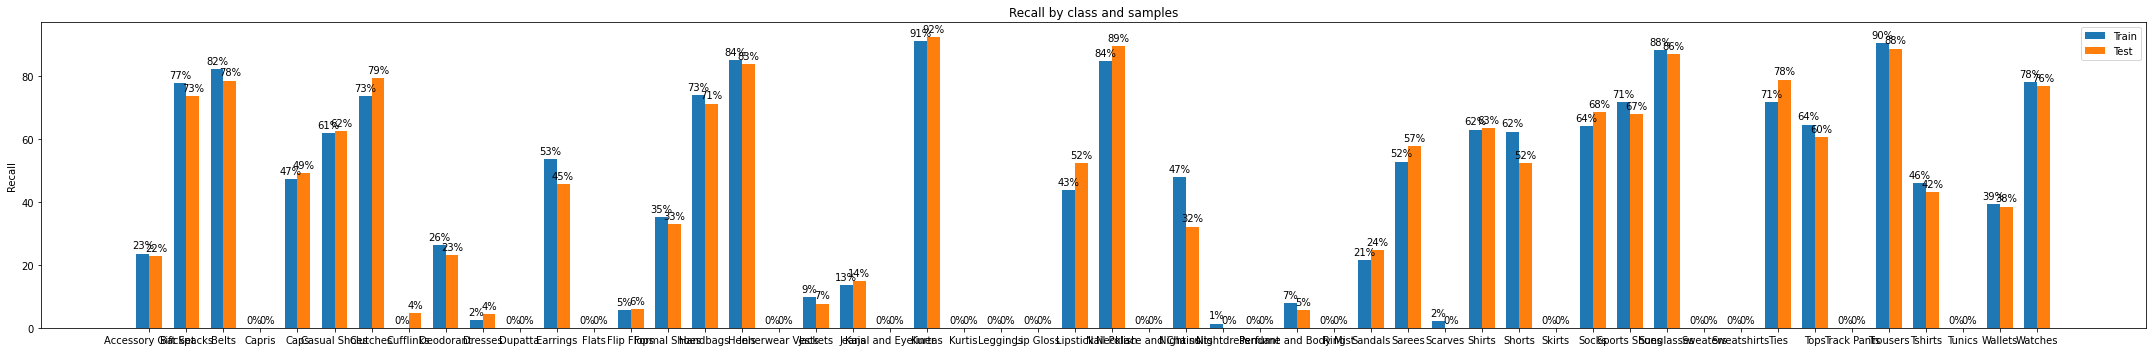

In [166]:
train_loader, test_loader = split_dataset(dataset, batch_size=128)

# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.03
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

در اینجا لرنینگ ریت رو کمتر از عددی که پیدا کردم گذاشتم و میبینیم ترین لاس هامون هم خیلی کوچیک داره تغییر میکنه و اکورسی هم کمی پایین اومده

37249 233 59
epoch 1, train_loss: 3.118, time elapsed: 11.895872 seconds
epoch 2, train_loss: 2.351, time elapsed: 11.9575 seconds
epoch 3, train_loss: 2.036, time elapsed: 12.034426 seconds
epoch 4, train_loss: 1.783, time elapsed: 11.981986 seconds
epoch 5, train_loss: 1.607, time elapsed: 12.00637 seconds
epoch 6, train_loss: 1.498, time elapsed: 11.902372 seconds
epoch 7, train_loss: 1.386, time elapsed: 11.927393 seconds
epoch 8, train_loss: 1.320, time elapsed: 11.919357 seconds
epoch 9, train_loss: 1.266, time elapsed: 11.961613 seconds
epoch 10, train_loss: 1.207, time elapsed: 12.000203 seconds
total training time: 1.993 minutes


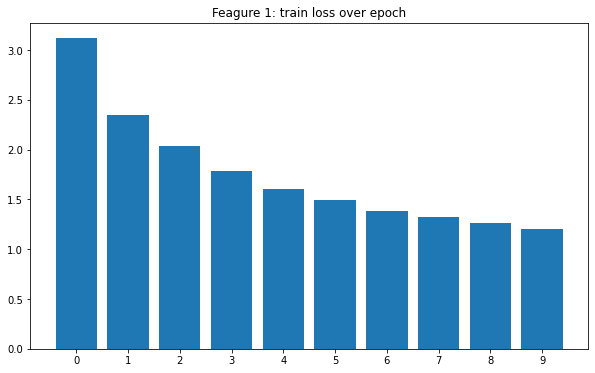

Train accuracy: 53.50179536226048, Test accuracy: 52.59060402684564

---------------- Train and Test accuracy for each class----------------



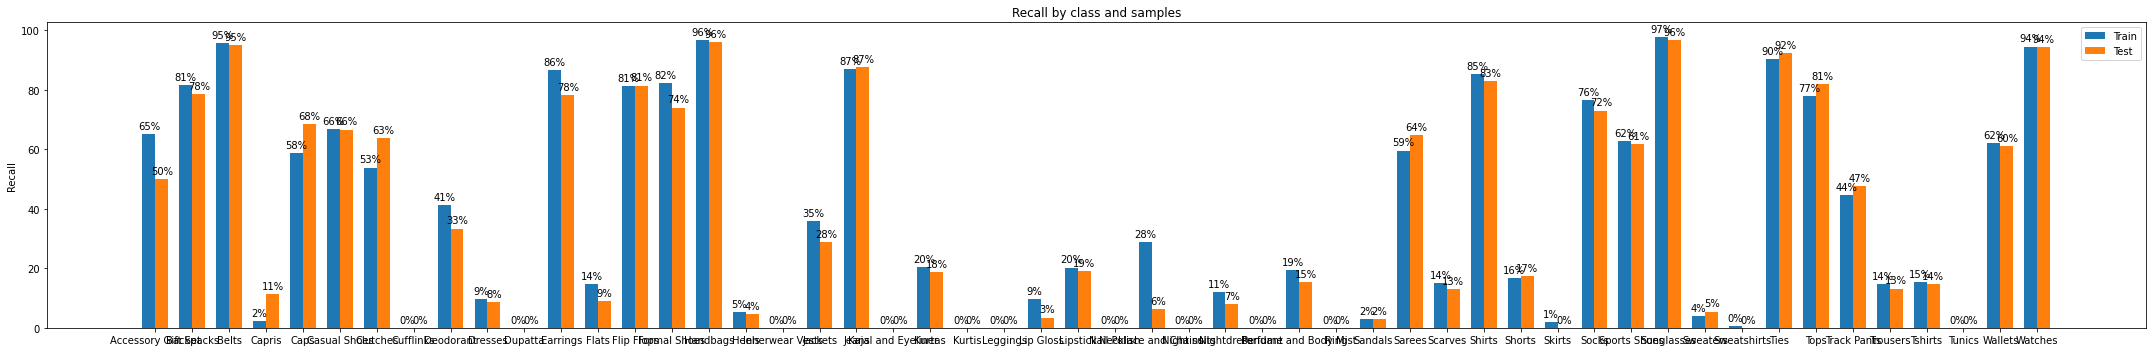

In [167]:
train_loader, test_loader = split_dataset(dataset, batch_size=128)

# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

اینجا لرنینگ ریت رو بیشتر از ۳.۵ درصد گذاشتم، قابل مشاهده است که ترینینگ لاس در طول اپوک ها بهتر میشن و اکورسی هم افزایش پیدا کرده  

## قسمت ۸

### الف

این متغیر باعث میشه تغییرات که به وزن هامون میدیم اسموث تر بشن، هر بار ما این تغییرات رو به صورت ضربی با تغییراتی که در گذشته دادیم جمع میکنیم و وزن ها رو آپدیت میکنیم، خوبی اینکار اینه که اگه در یکی از استپ های آپتیمایزرمون بچی نویزدار دیدیم این نویز تاثیر کمتری روی تغییراتی که میخوایم بدیم داره

بالا بردن این متغیر باعث میشه تاثیر تغییر فعلی خیلی کم بشه و تاثیر تغییرات گذشته بیشتر بشه

کلا توی استوکستیک داشتن تکینه معمولا خیلی الگوریتم بهینه سازمون رو بهبود میده، چون تقریبا عین اینه که ما بچ سایزمون رو زیاد کنیم، مسیر های آپتیمالی که الگورتیم آپتیمایزرمون به دست میاره به مسیر های آپتیمالی که روی کل سمپل دنبالش هستم نزدیک تر میشه و در نتیجه اکورسی کلیمون افزایش پیدا میکنه

اما مشکلاتی هم داره مثل همون مشکلاتی که توی زیاد کردن بچ سایز گفتیم، میتونه باعث اورفیتینگ بشه همچنین میتونه روند ترین کردن رو کند کنه چون هر بچ جدید تاثیر کمتری میزاره موقع آپدیت در نتیجه ممکنه مجبور به زیاد کردن اپوک هامون بشیم تا در آموزش مدلمون بتونیم به نقطه‌ی مینیموم لاس نزدیک شیم

### ب

37249 466 117
epoch 1, train_loss: 3.839, time elapsed: 17.824358 seconds
epoch 2, train_loss: 3.645, time elapsed: 17.855479 seconds
epoch 3, train_loss: 3.512, time elapsed: 17.842794 seconds
epoch 4, train_loss: 3.469, time elapsed: 17.782926 seconds
epoch 5, train_loss: 3.457, time elapsed: 17.909433 seconds
epoch 6, train_loss: 3.453, time elapsed: 17.790781 seconds
epoch 7, train_loss: 3.452, time elapsed: 17.835762 seconds
epoch 8, train_loss: 3.451, time elapsed: 17.843443 seconds
epoch 9, train_loss: 3.451, time elapsed: 17.800841 seconds
epoch 10, train_loss: 3.451, time elapsed: 17.793486 seconds
total training time: 2.971 minutes


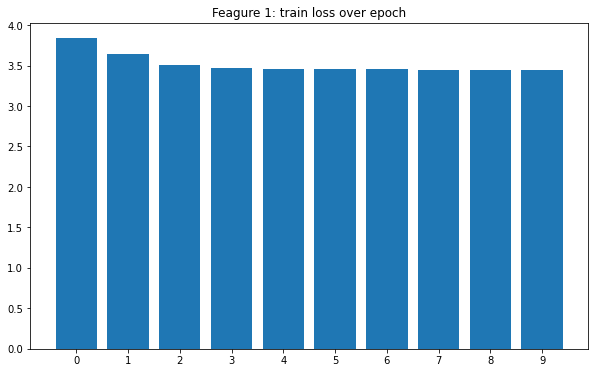

Train accuracy: 9.48689553340716, Test accuracy: 9.48993288590604

---------------- Train and Test accuracy for each class----------------



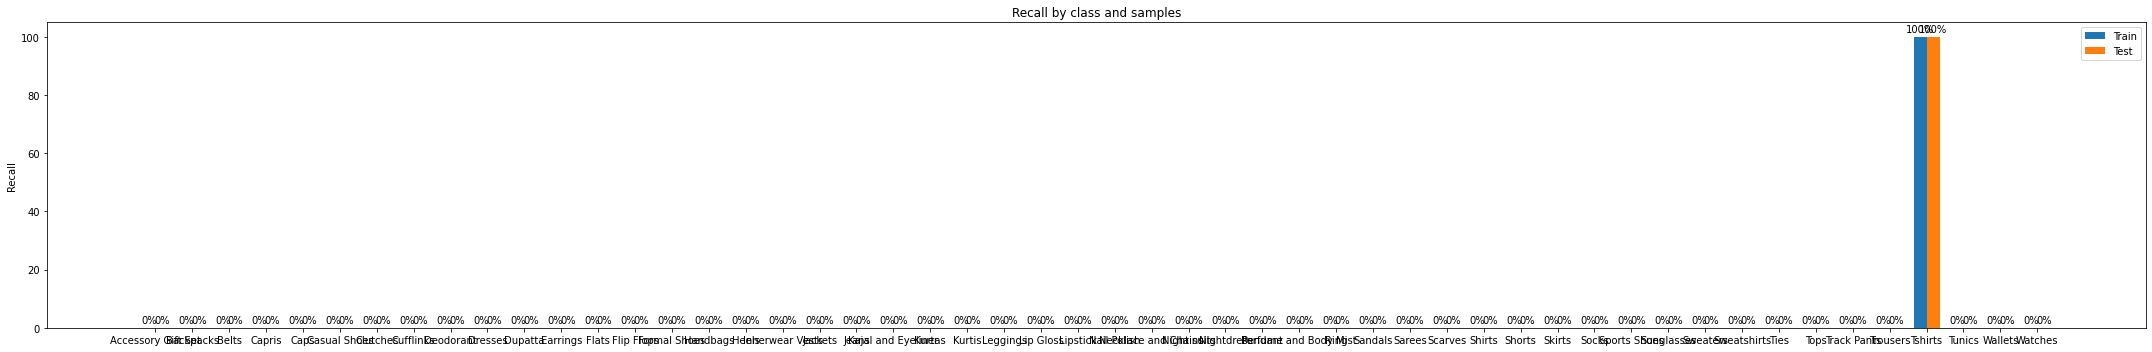

In [168]:
#return batch size to 64
train_loader, test_loader = split_dataset(dataset, batch_size=64)

# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
model.apply(init_weights)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

epoch 1, train_loss: 3.602, time elapsed: 17.967665 seconds
epoch 2, train_loss: 3.454, time elapsed: 17.866924 seconds
epoch 3, train_loss: 3.453, time elapsed: 17.827568 seconds
epoch 4, train_loss: 3.452, time elapsed: 17.834424 seconds
epoch 5, train_loss: 3.441, time elapsed: 17.775362 seconds
epoch 6, train_loss: 3.186, time elapsed: 17.767461 seconds
epoch 7, train_loss: 3.003, time elapsed: 17.790662 seconds
epoch 8, train_loss: 2.909, time elapsed: 17.864456 seconds
epoch 9, train_loss: 2.863, time elapsed: 17.796417 seconds
epoch 10, train_loss: 2.843, time elapsed: 17.792814 seconds
total training time: 2.971 minutes


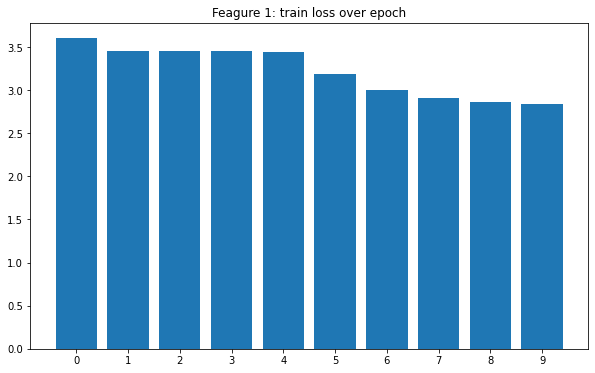

Train accuracy: 22.72895063592738, Test accuracy: 22.456375838926174

---------------- Train and Test accuracy for each class----------------



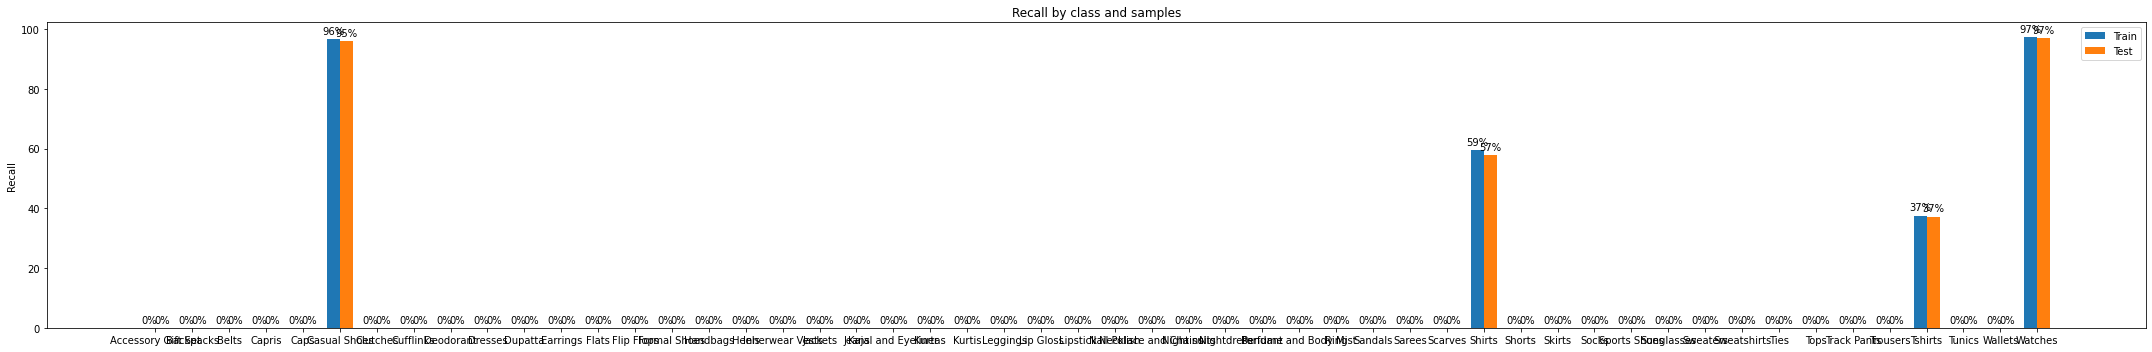

In [169]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
model.apply(init_weights)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

epoch 1, train_loss: 3.520, time elapsed: 17.860247 seconds
epoch 2, train_loss: 3.453, time elapsed: 17.817127 seconds
epoch 3, train_loss: 3.453, time elapsed: 17.79013 seconds
epoch 4, train_loss: 3.453, time elapsed: 17.808867 seconds
epoch 5, train_loss: 3.452, time elapsed: 17.795981 seconds
epoch 6, train_loss: 3.453, time elapsed: 17.843091 seconds
epoch 7, train_loss: 3.453, time elapsed: 17.916285 seconds
epoch 8, train_loss: 3.452, time elapsed: 17.826454 seconds
epoch 9, train_loss: 3.452, time elapsed: 17.805505 seconds
epoch 10, train_loss: 3.452, time elapsed: 17.837236 seconds
total training time: 2.972 minutes


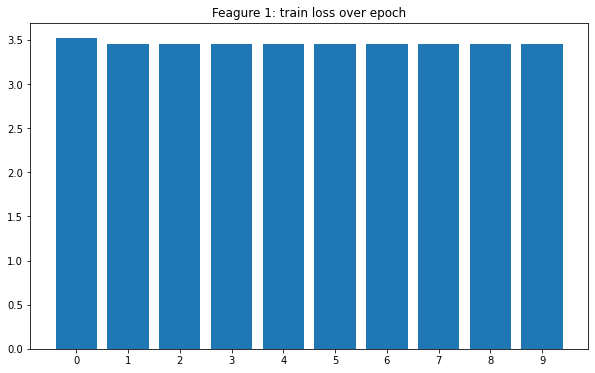

Train accuracy: 9.48689553340716, Test accuracy: 9.48993288590604

---------------- Train and Test accuracy for each class----------------



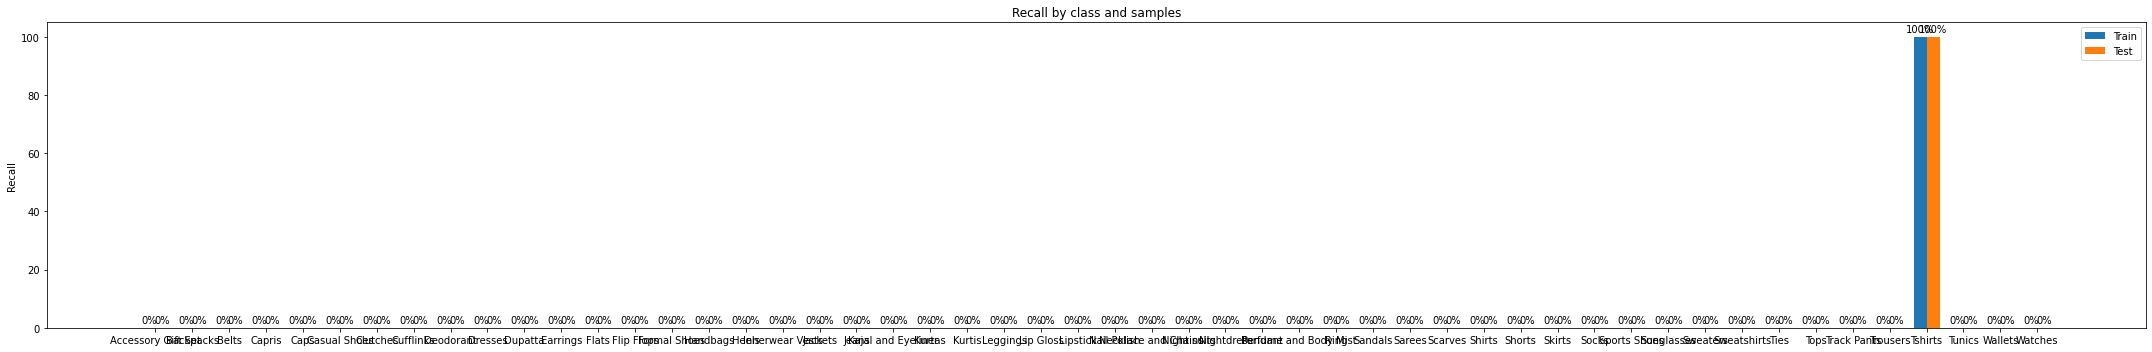

In [170]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.98)

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
model.apply(init_weights)

fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

با توجه به صفر بودن وزن ها انگار یک مدل خالی و سفید در اختیار فرآیند آموزش هست، این باعث میشه بر خلاف وزن های رندوم که در فرآیند آموزش اکثر لاس هامون به خاطر اشتباهات داخل این وزن هاست، در حالت صفر بودن وزن ها اشتباهات و لاس هامون به خاطر داده های نویزه بیشتر چون که وزنی وجود نداره که بخواد اصلاح بشه هر آپدیتمون مدل رو به شدت آپتیمایز میکنه برای اون بچ خاص، با توجه به اینکه خوبیه تکینه اینه که این نویز رو میگیره ترکیب وزن صفر و تکینه ۹۰ درصد خیلی ترکیب خوبی میشه و همونطور میبینیم میتونه درصد قابل قبولی رو جواب بده، البته با توجه به ویژگی تکینه نیاز به اپوک های بیشتری داریم که این مدلمون بتونه به قدرت مدل های با وزن رندوم برسه

تکینه کم مثل نیم چندان تاثیری نداره و تکینه‌ی خیلی زیاد مثل ۹۸ درصد هم نیاز به استپ های خیلی زیادی داره که بخواد فرآیند آموزش رو به خوبی طی کنه

### پ

افزایش بیش از حد تکانه باعث کند شدن فرآیند یادگیری میشه و ترین لاس ها با سرعت کمتری در طول اپوک ها تغییر میکنند
در نتیجه نیازه که تعداد اپوک رو زیاد کنیم و تایم بیشتری واسه عملیات آموزش بزاریم، نکته‌ی بعدی اینه که حتی اگه مشکلی با افزایش اپوک و افزایش تایم آموزش نداشته باشیم این افزایش تکانه باعث اورفیتینگ هم میشه و درصد اکورسی داده های آموزش بیشتر از تست میشه 

### مورد بهینه شماره ۸

epoch 1, train_loss: 2.453, time elapsed: 18.03688 seconds
epoch 2, train_loss: 1.626, time elapsed: 17.942051 seconds
epoch 3, train_loss: 1.392, time elapsed: 17.879953 seconds
epoch 4, train_loss: 1.259, time elapsed: 17.896419 seconds
epoch 5, train_loss: 1.161, time elapsed: 17.971745 seconds
epoch 6, train_loss: 1.085, time elapsed: 17.978413 seconds
epoch 7, train_loss: 1.024, time elapsed: 17.905151 seconds
epoch 8, train_loss: 0.977, time elapsed: 17.938197 seconds
epoch 9, train_loss: 0.942, time elapsed: 18.00473 seconds
epoch 10, train_loss: 0.898, time elapsed: 17.988364 seconds
total training time: 2.992 minutes


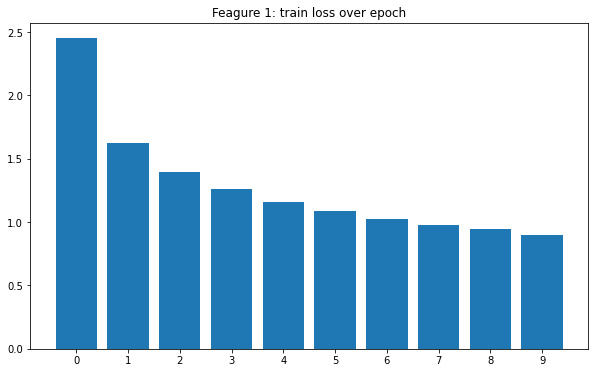

Train accuracy: 71.51582267861338, Test accuracy: 69.85234899328859

---------------- Train and Test accuracy for each class----------------



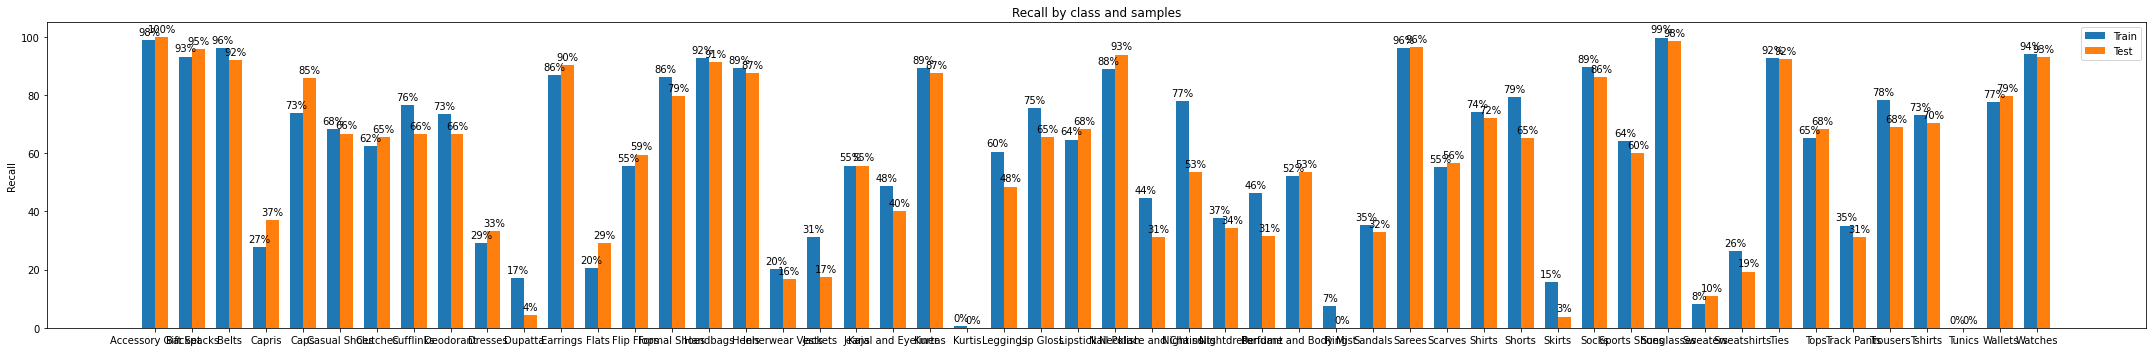

In [174]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7) #optimal momentum
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

## قسمت ۹

### الف

epoch 1, train_loss: 2.398, time elapsed: 17.770769 seconds
epoch 2, train_loss: 1.604, time elapsed: 17.837133 seconds
epoch 3, train_loss: 1.369, time elapsed: 17.864884 seconds
epoch 4, train_loss: 1.228, time elapsed: 17.931758 seconds
epoch 5, train_loss: 1.145, time elapsed: 17.844049 seconds
epoch 6, train_loss: 1.083, time elapsed: 17.881433 seconds
epoch 7, train_loss: 1.004, time elapsed: 17.940714 seconds
epoch 8, train_loss: 0.961, time elapsed: 17.859061 seconds
epoch 9, train_loss: 0.930, time elapsed: 18.020169 seconds
epoch 10, train_loss: 0.890, time elapsed: 17.796627 seconds
epoch 11, train_loss: 0.858, time elapsed: 17.818408 seconds
epoch 12, train_loss: 0.832, time elapsed: 17.86837 seconds
epoch 13, train_loss: 0.820, time elapsed: 17.932965 seconds
epoch 14, train_loss: 0.785, time elapsed: 18.020592 seconds
epoch 15, train_loss: 0.766, time elapsed: 17.818046 seconds
epoch 16, train_loss: 0.732, time elapsed: 17.924171 seconds
epoch 17, train_loss: 0.721, time 

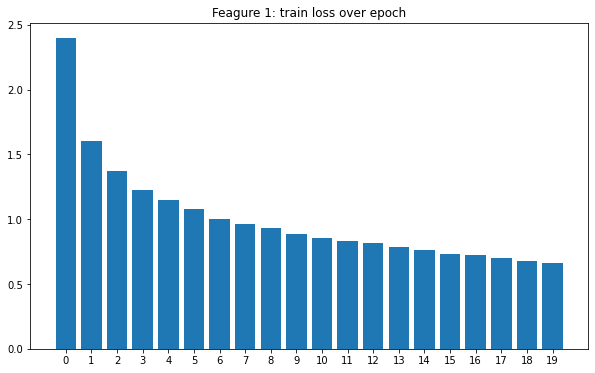

Train accuracy: 79.03285345145811, Test accuracy: 75.70469798657719

---------------- Train and Test accuracy for each class----------------



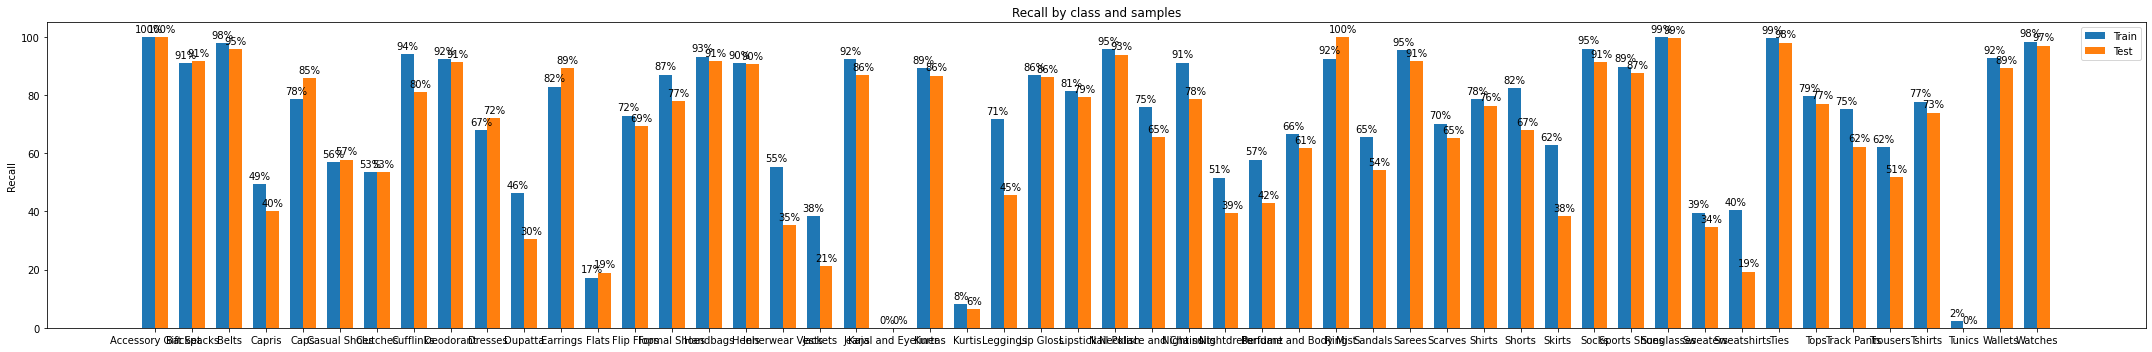

In [171]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7) #optimal momentum
fit(model, train_loader, device, criterion, optimizer, num_epochs=20)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

خوب این زیاد کردن باعث شد مدلمون تایم و استپ های بیشتری برای کم کردن هر چه بیشتر لاس داشته باشه

در نتیجه ترین لاس در آخر فرآیند کمتر از حالت با اپوک ۱۰ عه

اورفیتینگ هم در نمودار ها مشخصه

### ب

خوب با توجه به اینکه شبکه های عصبی سمپل ها رو به صورت بچ بچ آپتیمایز میکنن، بچ های آخر خیلی میتونن تاثیر بذارن روی فرآیند آموزش و اگه دارای نویز باشن میتونن وزن ها رو تا حدودی خراب کنن در نتیجه باید در چند راند یا اپوک بیایم و فرآیند رو روی تمام سمپل ها به صورت بچ بچ ران کنیم تا نتیجه‌ی بهتری بگیریم

یه نکته‌ی دیگه ائی هم که هست در حالت فول بچ که تمام سمپل ها آپتیمایز میشه میتونیم اپوک رو ۱ بزاریم چون آپتیمایزر وزن ها رو جوری آپتیمایز میکنه که به مینموم محلی میرسیم و نیازی به ادامه‌ی کار نیست

اما در حالت مینی بچ آپتیمایزر برای هر بچ آپتیمایز رو انجام میده و در ضریب لرنینگ ضرب میکنه و بعد اون رو با وزن ها جمع میکنه، در نتیجه میشه اینجوری در نظر گرفت که هر مینی بچ یه بردار کوچیکه که به مینیموم محلی نزدیکمون میکنه البته لزوما جهتش به سمت مینیموم محلی نیست با توجه به اینکه لرنینگ ریت پایینه تا جلوی نویز بگیریم در نتیجه نیازه با زیاد کردن اپوک هامون به این بردار های کوچیک کمک کنیم بردار اصلیمون رو به مینیموم محلی برسونن در حالی که اگه تعداد اپوک کم باشه این بردار ها فقط بردار وزن رو کمی بتونن نزدیک کنن به مینموم محلی

### پ

لزوما نه، در حالتی که لرنینگ ریتمون خیلی بالا باشه همونطور که قبلا گفتیم وزن هامون نوسان میزنن و ممکنه واگرا باشن در این حالت هر چی تعداد اپوک ها زیاد بشه واگرایی بیشتر و از حالت آپتیمایز مورد نظرمون دورتر میشیم، اما اگه لرنینگ ریت به اندازه انتخاب شده باشه اونوقت افزایش اپوک منجر به بهتر شدن میشه

معمولا از یه جایی به بعد روند کاهش ترین لاس خیلی ضعیف میشه که شاید ارزش زیاد کردن اپوک رو نداشته باشه دیگه

یا ممکنه به مینموم محلی رسیده باشیم و دیگه مدلمون بهتر نشه که اپوک های بعدی هیچ تاثیری روی مدل ندارن دیگه و صرفا باعث نوسان حول مینیمال محلی میشن

همچنین زیاد بودن تعداد اپوک باعث اورفیت هم میشه، مشکل دیگه اضافه شدن تایم آموزشه که واضحه

## قسمت ۱۰

epoch 1, train_loss: 2.393, time elapsed: 17.922138 seconds
epoch 2, train_loss: 1.665, time elapsed: 17.955322 seconds
epoch 3, train_loss: 1.386, time elapsed: 17.861184 seconds
epoch 4, train_loss: 1.246, time elapsed: 17.966836 seconds
epoch 5, train_loss: 1.151, time elapsed: 17.984371 seconds
epoch 6, train_loss: 1.081, time elapsed: 17.917257 seconds
epoch 7, train_loss: 1.035, time elapsed: 17.966446 seconds
epoch 8, train_loss: 0.976, time elapsed: 17.922755 seconds
epoch 9, train_loss: 0.929, time elapsed: 17.943201 seconds
epoch 10, train_loss: 0.904, time elapsed: 18.01115 seconds
total training time: 2.991 minutes


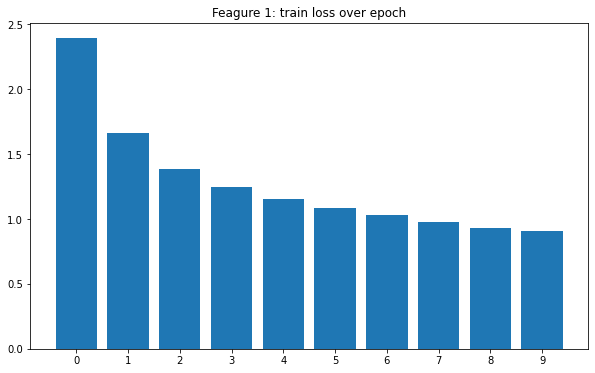

Train accuracy: 70.92855464948488, Test accuracy: 69.57046979865771

---------------- Train and Test accuracy for each class----------------



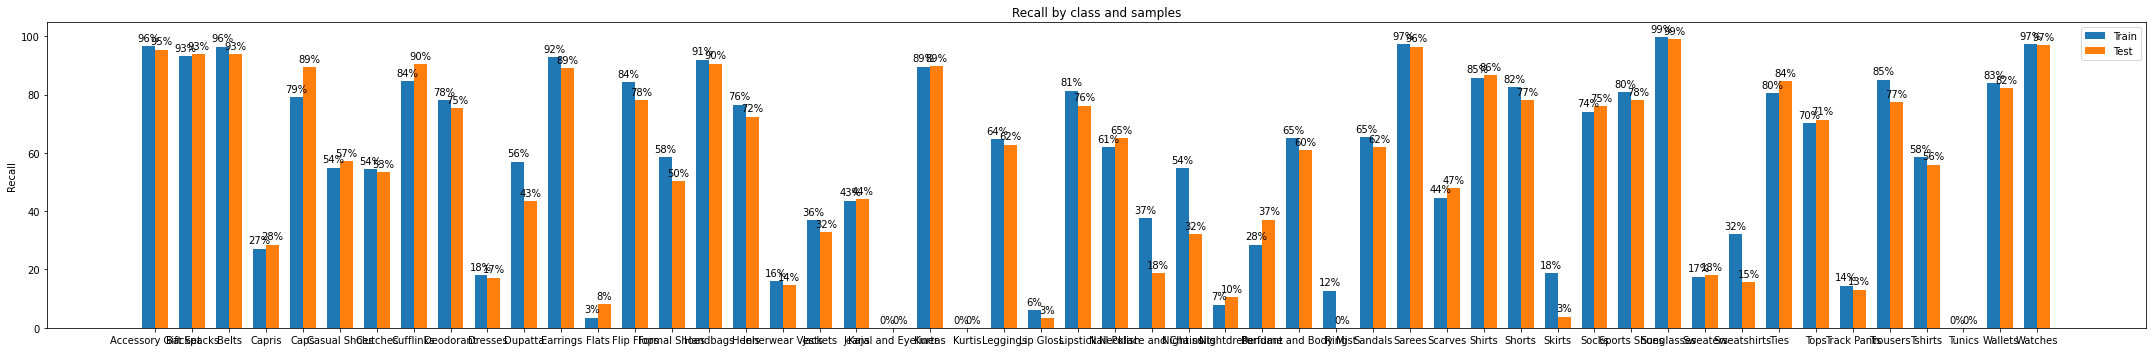

In [172]:
# initial model
model = Model(len(dataset.classes), act=F.leaky_relu)
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7) #optimal momentum
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 1.968, time elapsed: 17.927807 seconds
epoch 2, train_loss: 1.366, time elapsed: 18.023835 seconds
epoch 3, train_loss: 1.217, time elapsed: 18.021498 seconds
epoch 4, train_loss: 1.101, time elapsed: 17.963031 seconds
epoch 5, train_loss: 1.026, time elapsed: 17.985017 seconds
epoch 6, train_loss: 0.966, time elapsed: 18.090397 seconds
epoch 7, train_loss: 0.920, time elapsed: 18.03233 seconds
epoch 8, train_loss: 0.879, time elapsed: 18.013661 seconds
epoch 9, train_loss: 0.854, time elapsed: 17.909953 seconds
epoch 10, train_loss: 0.826, time elapsed: 17.983878 seconds
total training time: 2.999 minutes


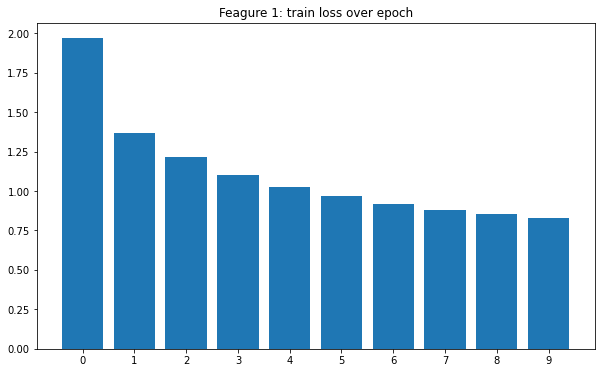

Train accuracy: 74.20383234336722, Test accuracy: 71.2751677852349

---------------- Train and Test accuracy for each class----------------



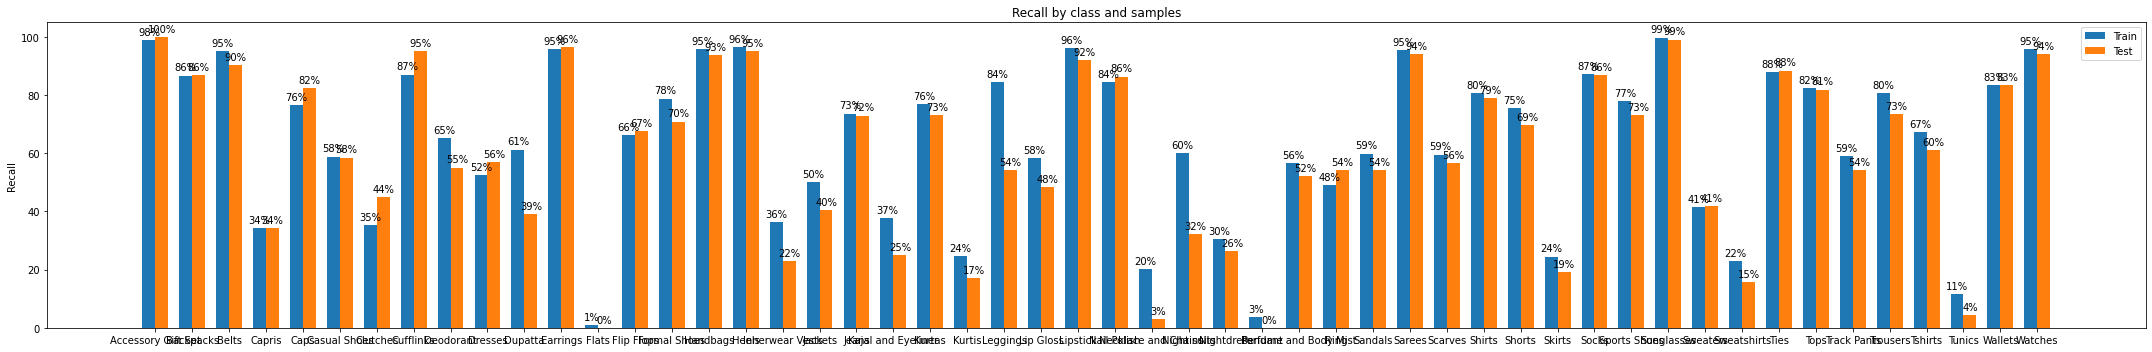

In [173]:
# initial model
model = Model(len(dataset.classes), act=F.tanh)
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7) #optimal momentum
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

توی مدل ما با توجه به نوع داده هایی که داریم و ترنسفورم هایی که روش زدیم به نظر تانژانت هایپربولیک بهتر از لیکی رلو عمل میکنه ولی عملکر مشابهی با رلو داره که در شماره ۸ تست کردیم

تفاوتی در زمان اجراشون دیده نمیشه

## قسمت ۱۱

### الف

کلا قضیه اینه که میام یه درصدی از وزن های قبلی (پارامتر های قبلی) رو به علاوه‌ی مشتقی که در مرحله‌ی لاس بدست آوردیم میکنیم

G(i) = dL/dW(i) + y*W(i)  which y is regulizer parameter

اینکار باعث میشه که در برابر نویز ها کمتر حساس باشیم و نمودار اسموث تر بشه، با زیاد کردن این مقدار میتونیم اجازه ندیم نمودارمون حالت های نویز و دورتر از باقی‌ حالت ها رو هندل کنه و اینجوری مانع اورفیتینگ میشه، اینکه میایم به علاوه‌ی وزن های قبلی میکنیم یعنی انگار داریم مقدار وزن قبلی رو توی خروجی تابع جی مون تاثیر میدیم و مانع از این میشیم که نویز ها زیاد روی این تابع تاثیر بزارن

نوع دیگری از رگولاریزیشن وجود داره که بعد از به دست آوردن وزن ها روی وزن ها زده میشه و نمودار رو اسموث میکنه

### ب

خوب توی این مدل ما هنگام بدست آوردن وزن های جدید یه درصدی رو داریم از وزن قبلیمون کم میکنیم و سپس با اضافه کردن جی تبدیل میشه به وزن جدید، که اگه دقت کنیم همون معادله‌ی بالاست

این معادله ائی که انجام میشه

W(i+1) = (1-n*y)W(i) - n*dL/dW(i) which n is learning rate and y is regulizer factor

که با معادله‌ی بالا یکسانه

W(i+1) = W(i) - G(i) **and** G(i) = dL/dW(i) + y*W(i) **-->** W(i+1) = (1-n*y)W(i) - n*dL/dW(i)

### پ

epoch 1, train_loss: 3.452, time elapsed: 19.855934 seconds
epoch 2, train_loss: 3.367, time elapsed: 19.982618 seconds
epoch 3, train_loss: 3.364, time elapsed: 20.077371 seconds
epoch 4, train_loss: 3.360, time elapsed: 19.852803 seconds
epoch 5, train_loss: 3.362, time elapsed: 19.916303 seconds
epoch 6, train_loss: 3.364, time elapsed: 19.926811 seconds
epoch 7, train_loss: 3.361, time elapsed: 20.005782 seconds
epoch 8, train_loss: 3.371, time elapsed: 19.881698 seconds
epoch 9, train_loss: 3.364, time elapsed: 19.865703 seconds
epoch 10, train_loss: 3.359, time elapsed: 19.886835 seconds
total training time: 3.321 minutes


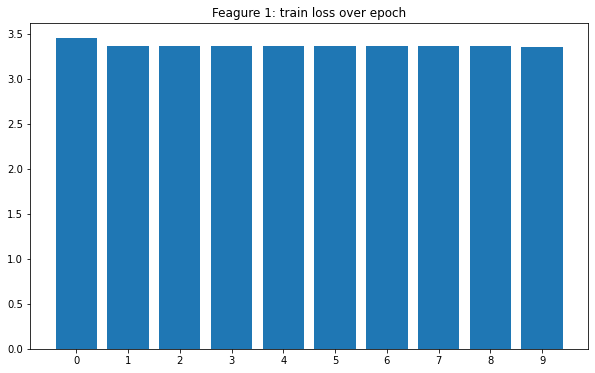

Train accuracy: 9.483539716097855, Test accuracy: 9.48993288590604

---------------- Train and Test accuracy for each class----------------



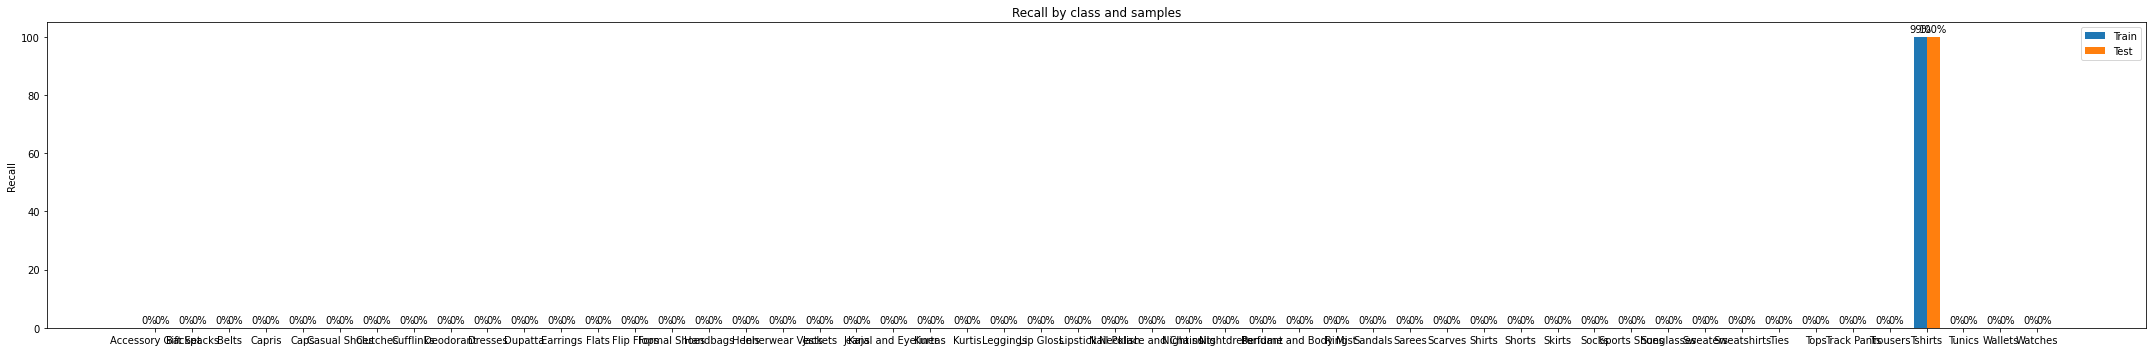

In [175]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, weight_decay=0.1)
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

با گذاشتن این مقدار درصدمون اکورسی مون خیلی ریخت همچنین ترین لاسمون خیلی زیاده و همونطور که دیده میشه خیلی تغییر نمیکنه ترین لاس در طول اپوک ها

ولی تغییری که قابل مشاهده است اینه که درصد اکورسی ترین و تستمون خیلی نزدیک همه و اورفیتینگ نداریم

کلا زیاد کردن این پارامتر باعث کاهش اکورسی ترین میشه اما اگه اورفیتینگ داشته باشیم میتونه باعث افزایش اکورسی تستمون بشه، همچنین تاثیر دیگه ائی که داره اینه که ترین لاس هامون خیلی کمتر تغییر میکنن دلیلش هم اینه که وزن هامون هیچ وقت کاملا روی سمپل های ترین فیت نمیشن در نتیجه معمولا ترین لاس روی یک مقداری باقی میمونه و بهبود پیدا نمیکنه

### ت

epoch 1, train_loss: 2.544, time elapsed: 20.011815 seconds
epoch 2, train_loss: 1.967, time elapsed: 19.904025 seconds
epoch 3, train_loss: 1.772, time elapsed: 19.855747 seconds
epoch 4, train_loss: 1.826, time elapsed: 19.929561 seconds
epoch 5, train_loss: 1.777, time elapsed: 20.133484 seconds
epoch 6, train_loss: 1.692, time elapsed: 19.907736 seconds
epoch 7, train_loss: 1.697, time elapsed: 19.80756 seconds
epoch 8, train_loss: 1.756, time elapsed: 19.874444 seconds
epoch 9, train_loss: 1.693, time elapsed: 19.900838 seconds
epoch 10, train_loss: 1.666, time elapsed: 19.887199 seconds
total training time: 3.320 minutes


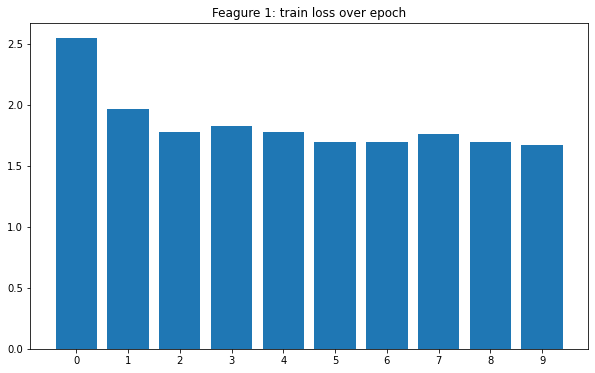

Train accuracy: 38.16571025873351, Test accuracy: 37.946308724832214

---------------- Train and Test accuracy for each class----------------



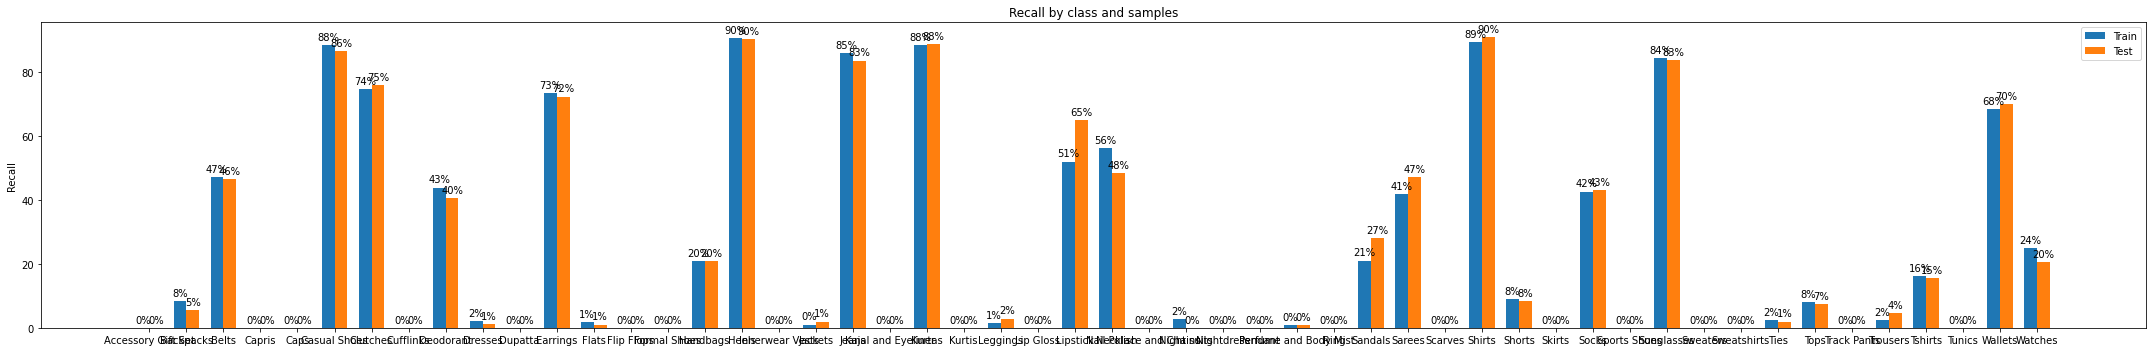

In [176]:
# initial model
model = Model(len(dataset.classes))
model = model.to(device)
learning_rate = 0.035
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, weight_decay=0.01)
fit(model, train_loader, device, criterion, optimizer)
test_model_accuracy(model, train_loader, test_loader, dataset.classes)

اینجا درصد هامون بهتر از حالت ۱۰ درصده اما بازم نصبت به حالت ۸ کمتره

توی حالت ۸ تفاوت بین اکورسی ترین و تستمون نزدیک به ۲، ۳ درصده اما در اینجا کمتر از ۱ درصده که نشون میده جلوی اورفیتینگ گرفته شده تا حدودی

نکته‌ی خیلی جالبی که توی نمودار ترین لاس ها مشخصه نوسان ترین لاس هستش، که مشخصه این مقداری که واسه پارامتر ست کردیم اجازه نمیده ترین لاسمون از مقداری پایین تر بره و اپوک های بعدی فقط روی همین مقدار بالا پایین میرن و نوسان میکنن